In [1]:
# Core data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical functions
from scipy.stats import skew

# Display utilities for Jupyter notebooks
from IPython.display import display

# Machine learning preprocessing and modeling
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Statistical
from scipy.stats import chi2_contingency
from scipy.stats import shapiro, probplot
from scipy.stats import mannwhitneyu
from scipy.stats import levene
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import kruskal

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500) # To display all the columns of dataframe
pd.set_option('max_colwidth', None) # To set the width of the column to maximum

In [2]:
# Load the datasets
df_student = pd.read_csv("/kaggle/input/student-habits-vs-academic-performance/student_habits_performance.csv")
# Verify shapes
print("Data Shape:", df_student.shape)

Data Shape: (1000, 16)


In [4]:
# Display few rows of each dataset
df_student.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [5]:
# Display information about the DataFrames
df_student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality               1000 non-null   ob

In [6]:
df_student.drop("student_id", axis=1, inplace=True)

In [7]:
# convert type data for categorical feature to category
cat_features = ["gender",  "part_time_job",  "diet_quality",  "parental_education_level",  "internet_quality",  "extracurricular_participation",
                "exercise_frequency", "mental_health_rating"]

def convert_cat(df, cat_features= cat_features):
    for feature in cat_features:
        if feature in df.columns:
            df[feature] = df[feature].astype("category")
        else:
            pass

convert_cat(df=df_student)
df_student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   age                            1000 non-null   int64   
 1   gender                         1000 non-null   category
 2   study_hours_per_day            1000 non-null   float64 
 3   social_media_hours             1000 non-null   float64 
 4   netflix_hours                  1000 non-null   float64 
 5   part_time_job                  1000 non-null   category
 6   attendance_percentage          1000 non-null   float64 
 7   sleep_hours                    1000 non-null   float64 
 8   diet_quality                   1000 non-null   category
 9   exercise_frequency             1000 non-null   category
 10  parental_education_level       909 non-null    category
 11  internet_quality               1000 non-null   category
 12  mental_health_rating           1000

In [8]:
print("Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df_student.describe().T.style.background_gradient(cmap=cm))

Data describe:


,count,mean,std,min,25%,50%,75%,max
age,1000.000000,20.498000,2.308100,17.000000,18.750000,20.000000,23.000000,24.000000
study_hours_per_day,1000.000000,3.550100,1.468890,0.000000,2.600000,3.500000,4.500000,8.300000
social_media_hours,1000.000000,2.505500,1.172422,0.000000,1.700000,2.500000,3.300000,7.200000
netflix_hours,1000.000000,1.819700,1.075118,0.000000,1.000000,1.800000,2.525000,5.400000
attendance_percentage,1000.000000,84.131700,9.399246,56.000000,78.000000,84.400000,91.025000,100.000000
sleep_hours,1000.000000,6.470100,1.226377,3.200000,5.600000,6.500000,7.300000,10.000000
exam_score,1000.000000,69.601500,16.888564,18.400000,58.475000,70.500000,81.325000,100.000000


In [9]:
def classify_exercise(x):
    if x in [0, 1]:
        return "Very inactive"
    elif x in [2, 3]:
        return "Occasionally active"
    else:
        return "Frequently exercises"

df_student["exercise_frequency"] = df_student["exercise_frequency"].apply(classify_exercise)

def classify_mental_health(x):
    if x <= 3:
        return "Low well-being"
    elif x <= 6:
        return "Moderate well-being"
    else:
        return "High well-being"

df_student["mental_health_rating"] = df_student["mental_health_rating"].apply(classify_mental_health)

In [10]:
df_student.describe(include=["category", "object"]).T

,count,unique,top,freq
gender,1000,3,Female,481
part_time_job,1000,2,No,785
diet_quality,1000,3,Fair,437
exercise_frequency,1000,3,Frequently exercises,435
parental_education_level,909,3,High School,392
internet_quality,1000,3,Good,447
mental_health_rating,1000,3,High well-being,382
extracurricular_participation,1000,2,No,682


In [11]:
# Replace all missing values (NaN) in the parental_education_level column of df_student with the most common value (mode) from that column.
df_student["parental_education_level"] = df_student["parental_education_level"].fillna(df_student["parental_education_level"].mode()[0])

In [12]:
def missing_values_report(df = df_student):
    missing_count = df.isnull().sum().sum()
    rows = len(df)
    
    print("=" * 80)
    print(f" Missing Value Analysis")
    print("=" * 80)
    
    if missing_count == 0:
        print(f"✅ No missing values detected in {rows:,} rows")
    else:
        print(f"⚠️  {missing_count} missing values found in {rows:,} rows")
missing_values_report()

 Missing Value Analysis
✅ No missing values detected in 1,000 rows


In [13]:
def check_duplicates_report(df=df_student):
    duplicates_count = df.duplicated().sum()
    total_rows = len(df)
    
    print("=" * 80)
    print(f"🔍 Duplicate Analysis")
    print("=" * 80)
    
    if duplicates_count == 0:
        print(f"✅ No duplicates found in {total_rows:,} rows")
    else:
        print(f"⚠️  {duplicates_count} duplicates found ({duplicates_count/total_rows:.2%})")
        print(f"    Total rows affected: {duplicates_count:,}/{total_rows:,}")

check_duplicates_report()

🔍 Duplicate Analysis
✅ No duplicates found in 1,000 rows


In [14]:
def checking_outlier(list_feature, df = df_student):
    outlier_info = []
    for feature in list_feature:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        if len(outliers) == 0:
            outlier_detail = ""
        else:
            outlier_detail = outliers.tolist()
        outlier_info.append({
            "Feature": feature,
            "Outlier Count": len(outliers),
            "Outlier Detail": outlier_detail
        })
    return pd.DataFrame(outlier_info)

# Source: https://www.geeksforgeeks.org/data-science/detect-and-remove-the-outliers-using-python/
def remove_outlier(list_feature, df = df_student):
    for feature in list_feature:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

In [15]:
num_feature = ["age", "study_hours_per_day", "social_media_hours", "netflix_hours", "attendance_percentage", "sleep_hours", "exam_score"]
all_feature = num_feature + cat_features
checking_outlier(list_feature=num_feature)

,Feature,Outlier Count,Outlier Detail
0,age,0,
1,study_hours_per_day,7,"[7.4, 7.4, 8.3, 7.4, 7.5, 8.2, 7.6]"
2,social_media_hours,5,"[6.2, 6.0, 6.1, 5.7, 7.2]"
3,netflix_hours,4,"[5.0, 5.4, 5.3, 4.9]"
4,attendance_percentage,3,"[57.6, 56.7, 56.0]"
5,sleep_hours,2,"[10.0, 10.0]"
6,exam_score,2,"[18.4, 23.1]"


In [16]:
def cal_ChiSquare(cat_feature, target_feature, df, show_expected = False, show_residuals = False):
    """
    Performs Chi-Square test of independence and visualizes the relationship between two categorical variables. <br>
    https://www.scribbr.com/statistics/chi-square-test-of-independence
    Parameters:
        cat_feature (str): Name of the categorical feature.
        target_feature (str): Name of the target categorical feature.
        df (pd.DataFrame): Input dataset.
        show_expected (bool): Whether to print expected frequencies. Default is False.
        show_residuals (bool): Whether to calculate and plot standardized residuals. Default is False.

    Returns:
        None - Prints test statistics, expected frequencies, and plots visualizations.
    """
    print(f"\n🔍 Chi-Square Test of Independence: '{cat_feature}' vs. '{target_feature}'")

    # Contingency table
    crosstab = pd.crosstab(df[cat_feature], df[target_feature])
    chi2, p, dof, expected = chi2_contingency(crosstab)

    print(f"Chi-squared statistic: {chi2:.3f}")
    print(f"Degrees of freedom: {dof}")
    print(f"p-value: {p:.6f}")

    if p < 0.05:
        print("🟢 Significant relationship found between variables (reject H₀).")
    else:
        print("⚪ No significant relationship found (fail to reject H₀).")

    # Optional: show expected frequencies
    if show_expected:
        print("\n📊 Expected Frequencies:")
        print(pd.DataFrame(expected, index=crosstab.index, columns=crosstab.columns))
    else:
        pass

    # Optional: show standardized residuals
    if show_residuals:
        residuals = (crosstab - expected) / np.sqrt(expected)
        print("\n📈 Standardized Residuals:")
        print(round(residuals, 2))

        # Heatmap of residuals
        plt.figure(figsize=(8, 6))
        sns.heatmap(residuals, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5)
        plt.title(f"Standardized Residuals Heatmap: {cat_feature} vs {target_feature}")
        plt.ylabel(cat_feature)
        plt.xlabel(target_feature)
        plt.tight_layout()
        plt.show()
    else:
        pass

def cal_shapiro(cat_feature, num_feature, df, plot_result = False):
    """
    Performs Shapiro-Wilk test to check for normal distribution of a numeric feature across groups. <br>
    https://www.statskingdom.com/shapiro-wilk-test-calculator.html
    Parameters:
        cat_feature (str): Name of the categorical feature.
        num_feature (str): Name of the numeric feature to test.
        df (pd.DataFrame): Input dataset.
        plot_result (bool): Show plot. Default is False.

    Returns:
        None - Prints test results and plots a histogram.
    """
    print(f"🔎 Shapiro-Wilk Normality Test for {num_feature} across {cat_feature} groups")

    for group in df[cat_feature].dropna().unique():
        data = df[df[cat_feature] == group][num_feature].dropna()
        n = len(data)

        if n < 3:
            print(f"⚠️ Group {group} has too few values ({n}) to perform Shapiro-Wilk test.")
        elif n > 5000:
            print(f"⚠️ Group {group} has {n} samples. Shapiro-Wilk may not be reliable for n > 5000.")
        else:
            stat, p = shapiro(data)
            print(f"Group: {group}")
            print(f"  Shapiro-Wilk statistic: {stat:.3f}")
            print(f"  p-value: {p:.6f}")
            if p > 0.05:
                print(f"  🟢 {group} appears to follow a normal distribution.\n")
            else:
                print(f"  ⚪ {group} does not appear to follow a normal distribution.\n")

            if plot_result:
                probplot(data, dist="norm", plot=plt)
                plt.title(f"QQ Plot - {group}")
                plt.show()
            else:
                pass

def cal_levene(dataframe, categorical_feature, num_feature, center="mean"):
    """
    Performs Levene’s test to assess the equality of variances across groups. <br>
    https://www.geeksforgeeks.org/levenes-test
    Parameters:
        dataframe (pd.DataFrame): The input dataset.
        categorical_feature (str): The name of the column representing the grouping variable (categorical).
        num_feature (str): The name of the column containing the numeric values to compare.
        center (str): Either 'mean' or 'median' — specifies the center of the distribution for the test.

    Returns:
        None - Prints the test statistic and conclusion.
    """
    print(f"🔍 Levene’s test: {num_feature} ~ {categorical_feature}")
    # Extract unique group labels
    groups = dataframe[categorical_feature].unique()    
    # Create a list of values for each group
    data_groups = [dataframe[dataframe[categorical_feature] == g][num_feature] for g in groups]    
    # Perform Levene’s test
    stat, p = levene(*data_groups, center=center)
    
    print(f"Levene statistic: {stat:.3f}")
    print(f"p-value: {p}")
    if p > 0.05:
        print("🟢 Variances are approximately equal across groups.")
    else:
        print("⚪ Variances are significantly different across groups.")

def cal_mannwhitneyu(dataframe, categorical_feature, num_feature, show_plot = False):
    """
    Performs Mann-Whitney U test (also known as Wilcoxon rank-sum test) to check for significant difference between two independent groups.
    https://library.virginia.edu/data/articles/the-wilcoxon-rank-sum-test
    Parameters:
        dataframe (pd.DataFrame): The input dataset.
        categorical_feature (str): The name of the column representing the grouping variable (categorical).
        num_feature (str): The name of the column containing the numeric values to compare.
        plot_result (bool): Show plot. Default is False.

    Returns:
        None - Prints the test statistic and conclusion.
    """

    # Extract unique groups
    groups = dataframe[categorical_feature].dropna().unique()
    
    if len(groups) != 2:
        print(f"❌ Error: Mann-Whitney U test requires exactly 2 groups, but found {len(groups)}.")
        return
    else:
        print(f"🔍 Mann-Whitney U test: {num_feature} ~ {categorical_feature}")
        # Extract values for each group
        group1 = dataframe[dataframe[categorical_feature] == groups[0]][num_feature].dropna()
        group2 = dataframe[dataframe[categorical_feature] == groups[1]][num_feature].dropna()

        # Perform Mann-Whitney U test
        stat, p = mannwhitneyu(group1, group2, alternative="two-sided")

        # Output results
        print(f"Mann-Whitney U statistic: {stat:.3f}")
        print(f"p-value: {p}")
        if p <= 0.05:
            print("🟢 There is a significant difference between the two groups.")
            n1, n2 = len(group1), len(group2)
            mean_U = n1 * n2 / 2
            std_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
            z = (stat - mean_U) / std_U
            r = z / np.sqrt(n1 + n2)
            # Interpret effect size
            if abs(r) < 0.1:
                interpretation = "Very small/negligible effect"
            elif abs(r) < 0.3:
                interpretation = "Small effect"
            elif abs(r) < 0.5:
                interpretation = "Medium effect"
            else:
                interpretation = "Large effect"
            print(f"📘 Interpretation: {interpretation}")
        else:
            print("⚪ There is no significant difference between the two groups.")

        # Show boxplot
        if show_plot:
            sns.boxplot(data=dataframe, x=categorical_feature, y=num_feature, palette="Set2")
            plt.title(f"Boxplot of {num_feature} by {categorical_feature}", fontsize=14, weight="bold")
            plt.tight_layout()
            plt.show()
        else:
            pass

def t_test_with_cohens_d(data, categorical_feature, num_feature, equal_var = False, show_plot = False):
    """
    Performs Independent T-Test between two groups and calculates Cohen's d. <br>
    https://www.scribbr.com/statistics/t-test/
    Parameters:
        data (pd.DataFrame): Input DataFrame.
        categorical_feature (str): Column name for grouping variable (categorical).
        num_feature (str): Column name for the numeric feature to compare.
        plot_result (bool): Show plot. Default is False.

    Returns:
        None - Prints T-test results and Cohen's d value.
    """

    # Extract unique groups
    groups = data[categorical_feature].dropna().unique()

    if len(groups) > 2:
        print(f"❌ Error: Independent T-Test requires 2 groups.")
        return
    else:
        print(f"🔍 Independent T-Test: {num_feature} ~ {categorical_feature}")
        # Extract values
        x1 = data[data[categorical_feature] == groups[0]][num_feature].dropna()
        x2 = data[data[categorical_feature] == groups[1]][num_feature].dropna()

        # T-test (independent)
        t_stat, p_value = ttest_ind(x1, x2, equal_var=equal_var)  # Welch’s t-test if variances may differ

        # Calculate Cohen’s d
        nx1, nx2 = len(x1), len(x2)
        pooled_std = np.sqrt(((nx1 - 1)*np.var(x1, ddof=1) + (nx2 - 1)*np.var(x2, ddof=1)) / (nx1 + nx2 - 2))
        cohens_d = (np.mean(x1) - np.mean(x2)) / pooled_std

        # Output
        print(f"\n🔍 T-Test between group'{groups[0]}' and group '{groups[1]}':")
        print(f"t-statistic: {t_stat:.3f}")
        print(f"p-value: {p_value:.6f}")

        if p_value < 0.05:
            print("\n✅ Significant difference found (p < 0.05)")
            print(f"\n📏 Cohen's d: {cohens_d:.3f}")            
            # Interpretation of Cohen's d
            if abs(cohens_d) < 0.2:
                size = "small"
            elif abs(cohens_d) < 0.5:
                size = "medium"
            else:
                size = "large"
            print(f"🧠 Effect size interpretation: {size} effect")
        else:
            print("\nℹ️ No significant difference found (p >= 0.05)")
        
        # Show boxplot
        if show_plot:
            sns.boxplot(data=data, x=categorical_feature, y=num_feature, palette="Set2")
            plt.title(f"Boxplot of {num_feature} by {categorical_feature}", fontsize=14, weight="bold")
            plt.tight_layout()
            plt.show()
        else:
            pass

def perform_anova_with_tukey(df, numeric_feature, categorical_feature, typ=2, plot=False):
    """
    Performs ANOVA and Tukey's HSD post-hoc test if needed. <br>
    https://www.scribbr.com/statistics/one-way-anova/
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        numeric_feature (str): Name of the numerical response variable.
        categorical_feature (str): Name of the categorical variable (independent).
        typ (int): Type of sum of squares to use (1, 2, or 3). Default is 2.
        plot (bool): Show plot. Default is False.

    Returns:
        None - Prints ANOVA results and optionally Tukey's HSD results.
    """

    # Extract unique groups
    groups = df[categorical_feature].dropna().unique()
    
    if len(groups) < 3:
        print(f"❌ Error: ANOVA requires 3 or more groups.")
        return
    else:
        print(f"\n🔍 ANOVA Test: {numeric_feature} ~ {categorical_feature} (Type {typ})")

        # Fit OLS model
        model = ols(f"{numeric_feature} ~ C({categorical_feature})", data=df).fit()

        # Perform ANOVA
        anova_table = anova_lm(model, typ=typ)
        print("\n📊 ANOVA Table:")
        print(anova_table)

        # Extract p-value
        p_value = anova_table["PR(>F)"].iloc[0]

        if p_value < 0.05:
            print("\n✅ Significant difference found (p < 0.05)")
            print("➡️ Performing Tukey's HSD post-hoc test:")

            tukey = pairwise_tukeyhsd(df[numeric_feature], df[categorical_feature])
            print(tukey.summary())
        else:
            print("\nℹ️ No significant difference found (p >= 0.05)")

        if plot:
            sns.boxplot(data=df, x=categorical_feature, y=numeric_feature, palette="Set2")
            plt.title(f"Boxplot of {numeric_feature} by {categorical_feature}", fontsize=14, weight="bold")
            plt.tight_layout()
            plt.show()
        else:
            pass

def perform_kruskal_test(df, categorical_feature, numeric_feature, plot = False):
    """
    Performs Kruskal-Wallis H-test for independent samples. <br>
    https://www.geeksforgeeks.org/kruskal-wallis-test
    Parameters:
        df (pd.DataFrame): Dataset.
        categorical_feature (str): Categorical column name.
        numeric_feature (str): Numerical column name.
        plot (bool): Show plot. Default is False.

    Returns:
        None - Prints Kruskal-Wallis test results.
    """
    import scikit_posthocs as sp
    # Extract values
    groups = df[categorical_feature].dropna().unique()
    if len(groups) < 3:
        print(f"❌ Error: Kruskal-Wallis H-test requires 3 or more groups.")
        return
    else:
        print(f"\n🔍 Kruskal-Wallis Test: {numeric_feature} ~ {categorical_feature}")
        data_groups = [df[df[categorical_feature] == g][numeric_feature].dropna() for g in groups]

        # Perform kruskal
        stat, p = kruskal(*data_groups)

        print(f"Kruskal-Wallis H-statistic: {stat:.3f}")
        print(f"p-value: {p}")
        
        if p < 0.05:
            print("🟢 Significant difference found. Running Dunn's Post-Hoc Test...")
            dunn_result = sp.posthoc_dunn(df, val_col=numeric_feature, group_col=categorical_feature, p_adjust="bonferroni")
            print(dunn_result)
        else:
            print("\nℹ️ No significant difference found (p >= 0.05)")

        # Boxplot
        if plot:
            sns.boxplot(data=df, x=categorical_feature, y=numeric_feature, palette="Set2")
            plt.title(f"Boxplot of {numeric_feature} by {categorical_feature}", fontsize=14, weight="bold")
            plt.tight_layout()
            plt.show()
        else:
            pass

In [17]:
df_student["exam_score_cat"] = pd.cut(df_student["exam_score"],
                                      bins = [-0.1, 59, 69, 79, 89, 100],
                                      labels=["F", "D", "C", "B", "A"])

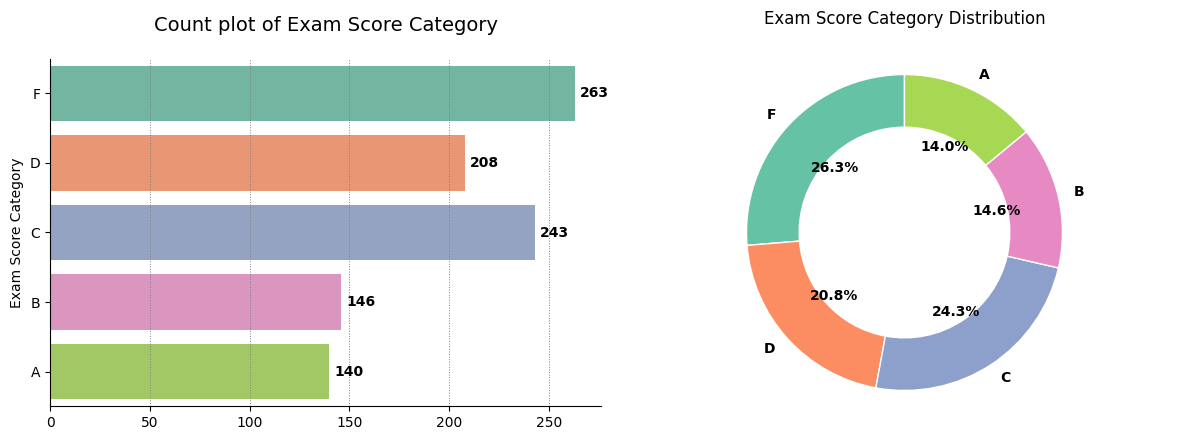

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12, 4.5))

sns.countplot(data=df_student, y = "exam_score_cat", ax=ax[0], palette="Set2")
ax[0].set_title(f"Count plot of Exam Score Category", fontsize=14, pad=20)
ax[0].set_ylabel("Exam Score Category")
ax[0].set_xlabel("")
ax[0].grid(axis="x", color="gray", linestyle=":", linewidth=0.7)
sns.despine(ax=ax[0], top=True, right=True, left=False, bottom=False)

for p in ax[0].patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax[0].text(width + max(df_student["exam_score_cat"].value_counts())*0.01, y,
            f'{int(width)}', 
            ha="left", va="center", fontsize=10, fontweight="bold", color="black")

fertilizer_counts = df_student["exam_score_cat"].value_counts().sort_index()
wedges, texts, autotexts = ax[1].pie(
    fertilizer_counts,
    labels=fertilizer_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("Set2", len(fertilizer_counts)),
    wedgeprops=dict(width=0.4, edgecolor="w"),
    radius=1.2
)

for text in texts + autotexts:
    text.set_fontsize(10)
    text.set_fontweight('bold')

centre_circle = plt.Circle((0, 0), 0.70, fc="white")
ax[1].add_artist(centre_circle)
ax[1].set_title(f"Exam Score Category Distribution", pad=25)
ax[1].axis("equal")

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


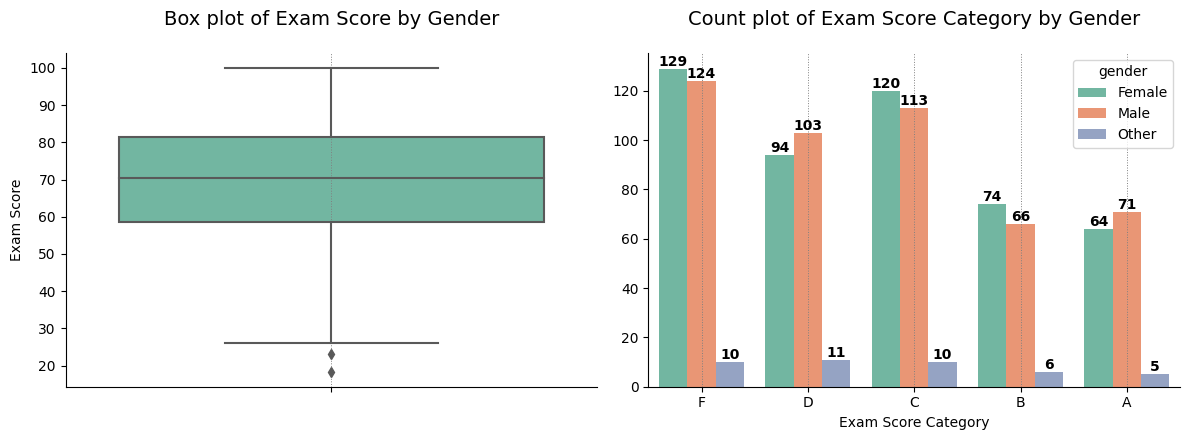

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12, 4.5))

sns.boxplot(data=df_student, y = "exam_score", ax=ax[0], palette="Set2", hue="gender")
ax[0].set_title(f"Box plot of Exam Score by Gender", fontsize=14, pad=20)
ax[0].grid(axis="x", color="gray", linestyle=":", linewidth=0.7)
ax[0].set_ylabel("Exam Score")
sns.despine(ax=ax[0], top=True, right=True, left=False, bottom=False)
ax[0].legend().remove()

sns.countplot(data=df_student, x = "exam_score_cat", ax=ax[1], palette="Set2", hue="gender")
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%d', label_type="edge", fontsize=10, weight="bold")
ax[1].set_title(f"Count plot of Exam Score Category by Gender", fontsize=14, pad=20)
ax[1].set_xlabel("Exam Score Category")
ax[1].set_ylabel("")
ax[1].grid(axis="x", color="gray", linestyle=":", linewidth=0.7)
sns.despine(ax=ax[1], top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

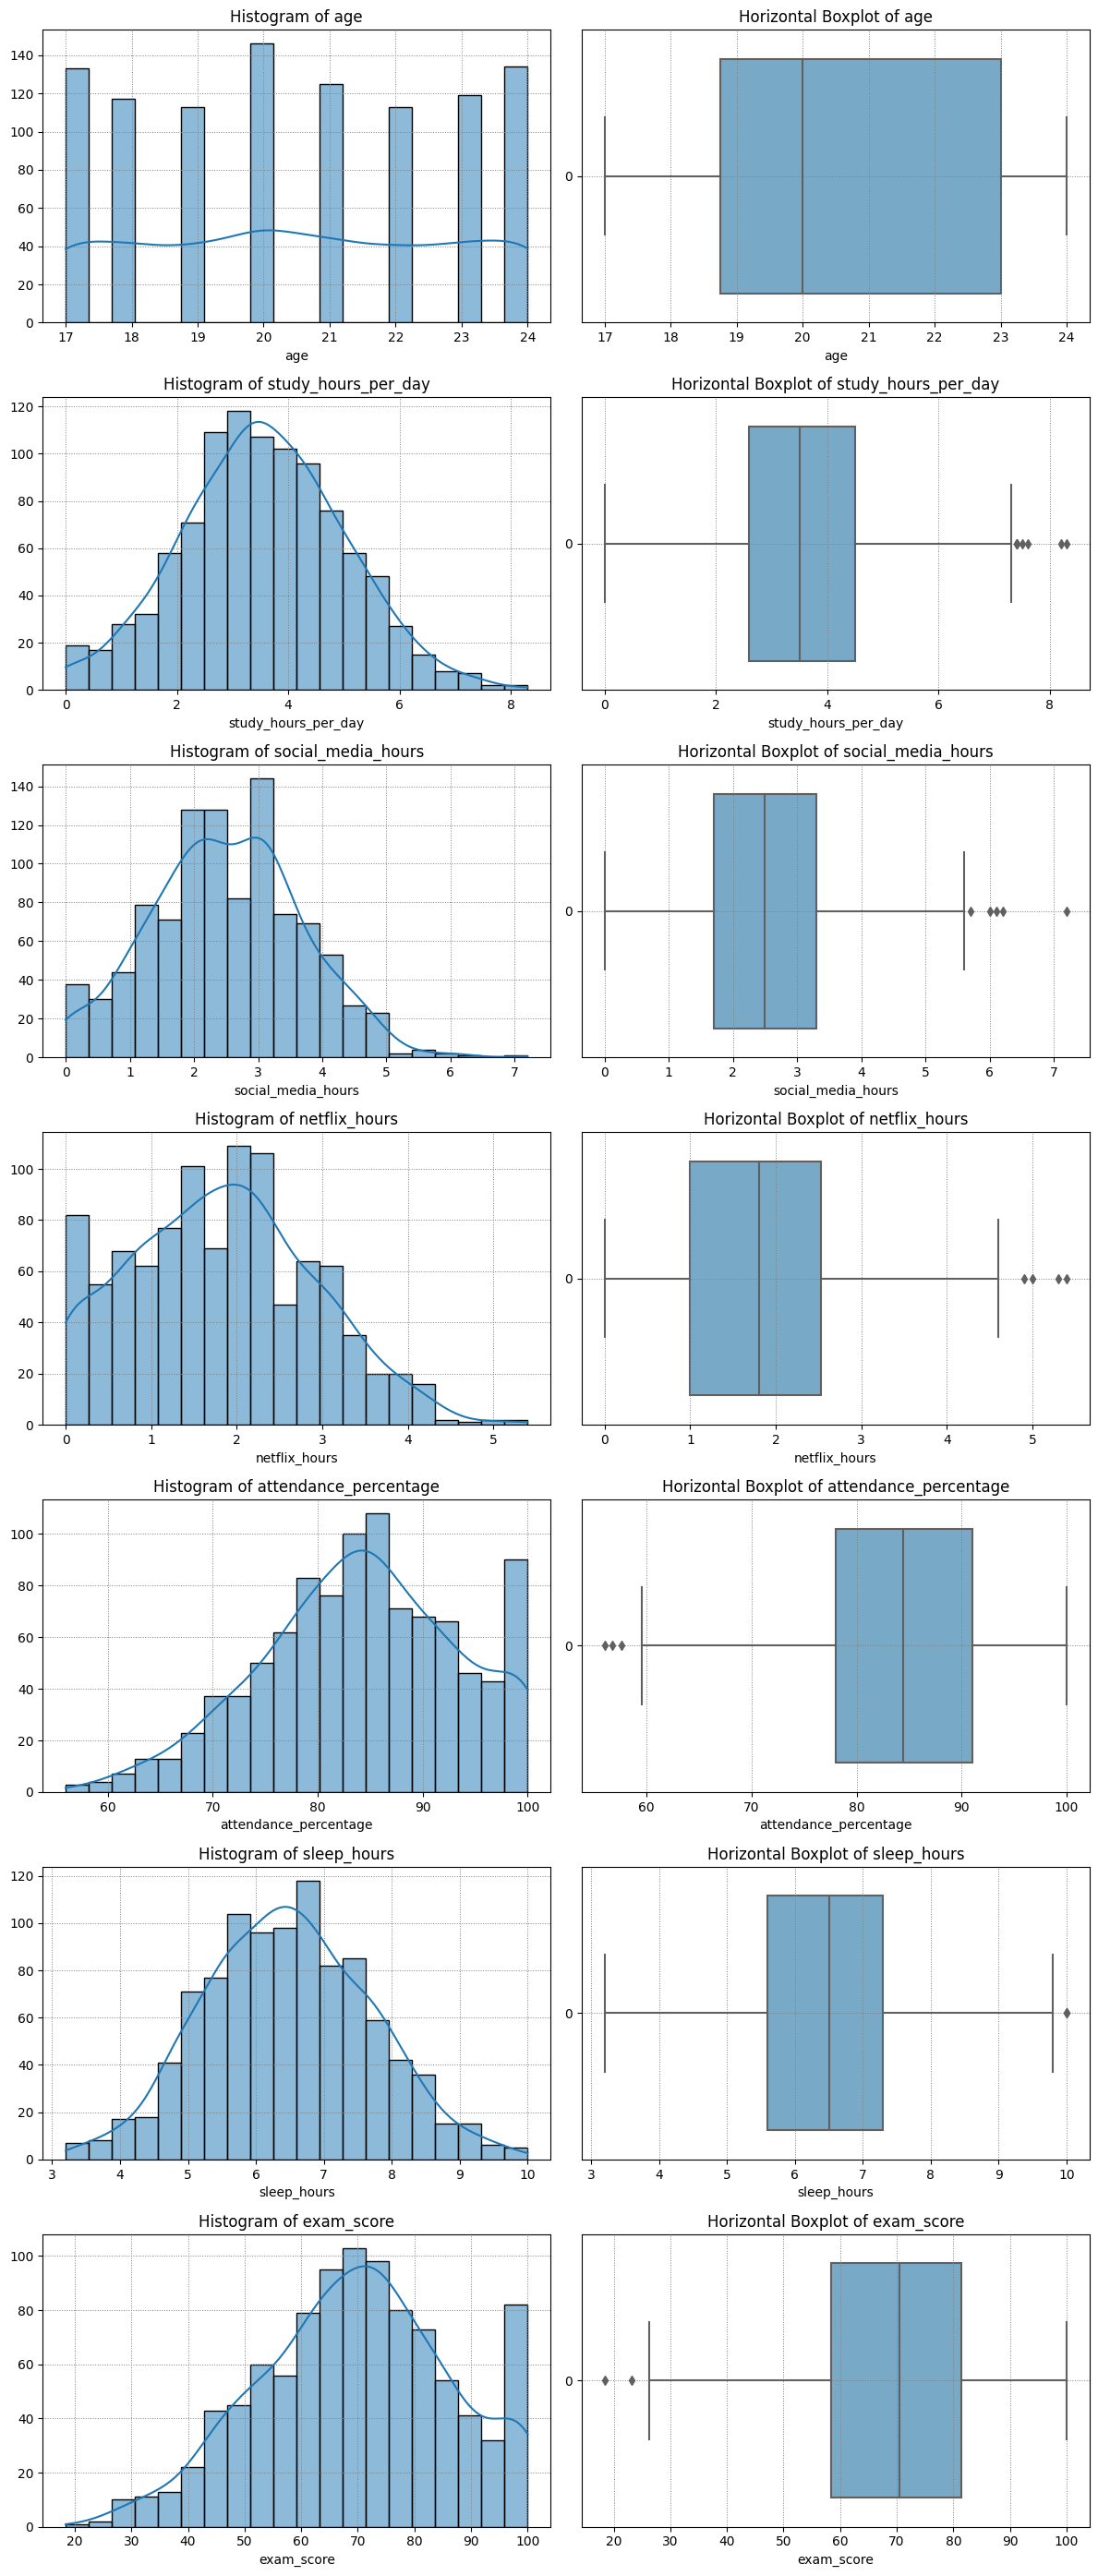

In [20]:
def plot_numerical_features(df=df_student, numerical_features = num_feature):
    fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, len(numerical_features)*4))
    axes = np.atleast_2d(axes)

    for i, feature in enumerate(numerical_features):
        sns.histplot(data=df_student[feature], palette="Blues", bins = 20, kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f"Histogram of {feature}")
        axes[i, 0].set_ylabel("")
        # axes[i, 0].set_facecolor("lightgray")
        axes[i, 0].grid(color="gray", linestyle=":", linewidth=0.7)

        sns.boxplot(data=df_student[feature], palette="Blues", orient="h", ax=axes[i, 1])
        axes[i, 1].set_title(f"Horizontal Boxplot of {feature}")
        axes[i, 1].set_xlabel(feature)
        # axes[i, 1].set_facecolor("lightgray")
        axes[i, 1].grid(color="gray", linestyle=":", linewidth=0.7)

    plt.tight_layout()
    plt.show()
plot_numerical_features()

In [21]:
def check_skewness(data = df_student, numerical_features = num_feature, highlight=True, sort=True):
    skewness_dict = {}
    for feature in numerical_features:
        skew = data[feature].skew(skipna=True)
        skewness_dict[feature] = skew

    skew_df = pd.DataFrame.from_dict(skewness_dict, orient='index', columns=['Skewness'])
    if sort:
        skew_df = skew_df.reindex(skew_df['Skewness'].abs().sort_values(ascending=False).index)
    
    print(f"\n🔍 Skewness for dataset:")
    print("-"*60)
    print(f"{'Feature':<21} | {'Skewness':<10} | {'Remark'}")
    print("-"*60)
    for feature, row in skew_df.iterrows():
        skew = row['Skewness']
        abs_skew = abs(skew)
        if abs_skew > 1:
            remark = "Highly skewed"
            color = "\033[91m"  
        elif abs_skew > 0.5:
            remark = "Moderately skewed"
            color = "\033[93m"  
        else:
            remark = "Approximately symmetric"
            color = ''
        endc = '\033[0m' if color else ''
        if highlight and color:
            print(f"{color}{feature:<21} | {skew:>+9.4f} | {remark}{endc}")
        else:
            print(f"{feature:<21} | {skew:>+9.4f} | {remark}")
    print("-"*60)
    return skew_df

skew_data = check_skewness()


🔍 Skewness for dataset:
------------------------------------------------------------
Feature               | Skewness   | Remark
------------------------------------------------------------
attendance_percentage |   -0.2378 | Approximately symmetric
netflix_hours         |   +0.2372 | Approximately symmetric
exam_score            |   -0.1564 | Approximately symmetric
social_media_hours    |   +0.1198 | Approximately symmetric
sleep_hours           |   +0.0915 | Approximately symmetric
study_hours_per_day   |   +0.0543 | Approximately symmetric
age                   |   +0.0084 | Approximately symmetric
------------------------------------------------------------


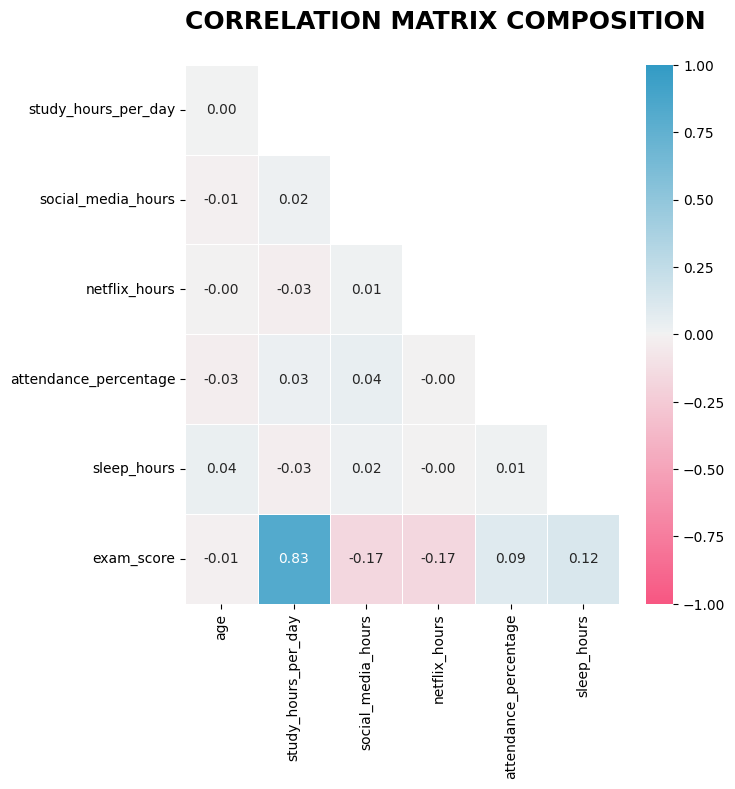

In [22]:
corr_matrix = df_student.corr(numeric_only=True)
# one_like can build a matrix of boolean(True, False) with the same shape as our data
ones_corr = np.ones_like(corr_matrix, dtype=bool)
mask = np.triu(ones_corr)
adjusted_mask = mask[1:, :-1]
adjusted_cereal_corr = corr_matrix.iloc[1:, :-1]

fig, ax = plt.subplots(figsize = (7, 7))
# That method uses HUSL colors, so you need hue, saturation, and lightness. 
# I used hsluv.org to select the colors of this chart.
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

sns.heatmap(data=adjusted_cereal_corr, mask=adjusted_mask,
            annot=True, fmt=".2f", cmap=cmap,
            vmin=-1, vmax=1, linecolor="white", linewidths=0.5)

title = 'CORRELATION MATRIX COMPOSITION\n'
ax.set_title(title, loc='left', fontsize=18, weight="bold");

In [23]:
# Function to display barplot and pie chart for categorical columns
def plot_categorical_distribution(feature, df = df_student):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12, 4.5))

    sns.countplot(data=df, y = feature, ax=ax[0], palette="Set2")
    ax[0].set_title(f"Count plot of {feature}", fontsize=14, pad=20)
    ax[0].set_ylabel(feature)
    ax[0].set_xlabel("")
    ax[0].grid(axis="x", color="gray", linestyle=":", linewidth=0.7)
    sns.despine(ax=ax[0], top=True, right=True, left=False, bottom=False)

    for p in ax[0].patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax[0].text(width + max(df[feature].value_counts())*0.01, y,
                f'{int(width)}', 
                ha="left", va="center", fontsize=10, fontweight="bold", color="black")

    fertilizer_counts = df[feature].value_counts().sort_index()
    wedges, texts, autotexts = ax[1].pie(
        fertilizer_counts,
        labels=fertilizer_counts.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=sns.color_palette("Set2", len(fertilizer_counts)),
        wedgeprops=dict(width=0.4, edgecolor="w"),
        radius=1.2
    )

    for text in texts + autotexts:
        text.set_fontsize(10)
        text.set_fontweight('bold')

    centre_circle = plt.Circle((0, 0), 0.70, fc="white")
    ax[1].add_artist(centre_circle)
    ax[1].set_title(f"Percentage Distribution of {feature}", pad=25)
    ax[1].axis("equal")

    plt.tight_layout()
    plt.show()

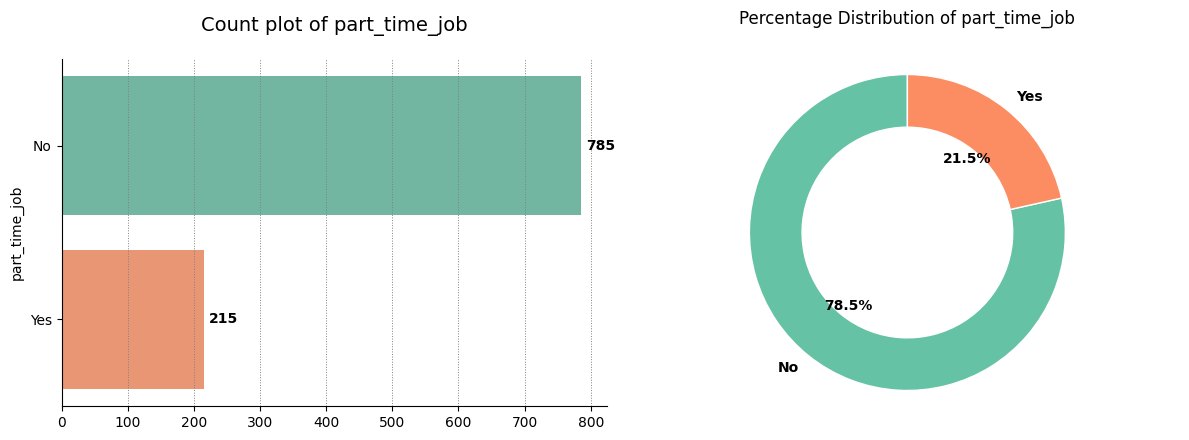

In [24]:
plot_categorical_distribution(feature="part_time_job")

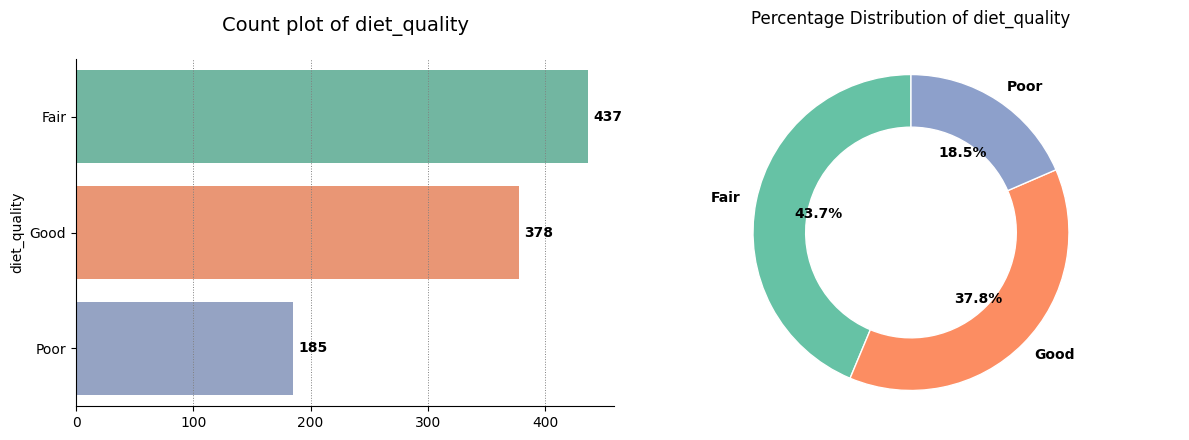

In [25]:
plot_categorical_distribution(feature="diet_quality")

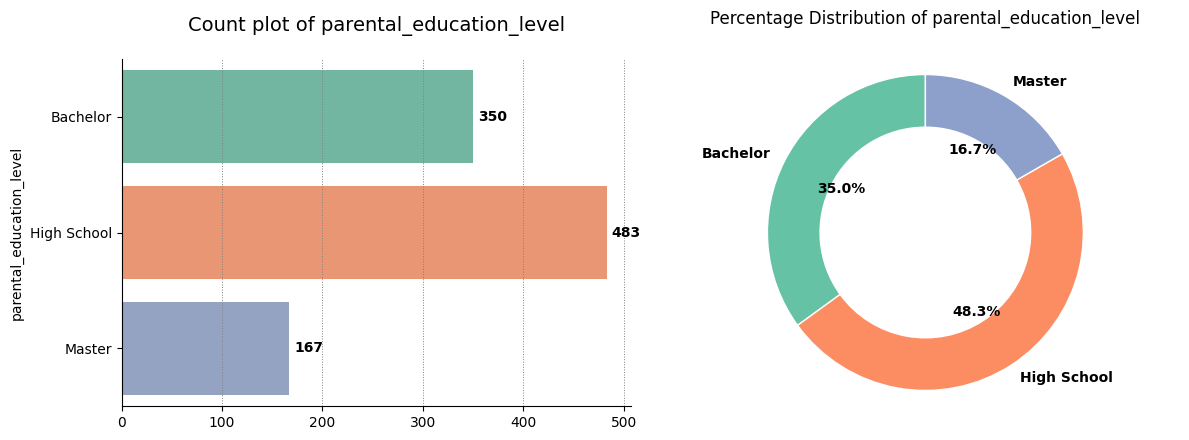

In [26]:
plot_categorical_distribution(feature="parental_education_level")


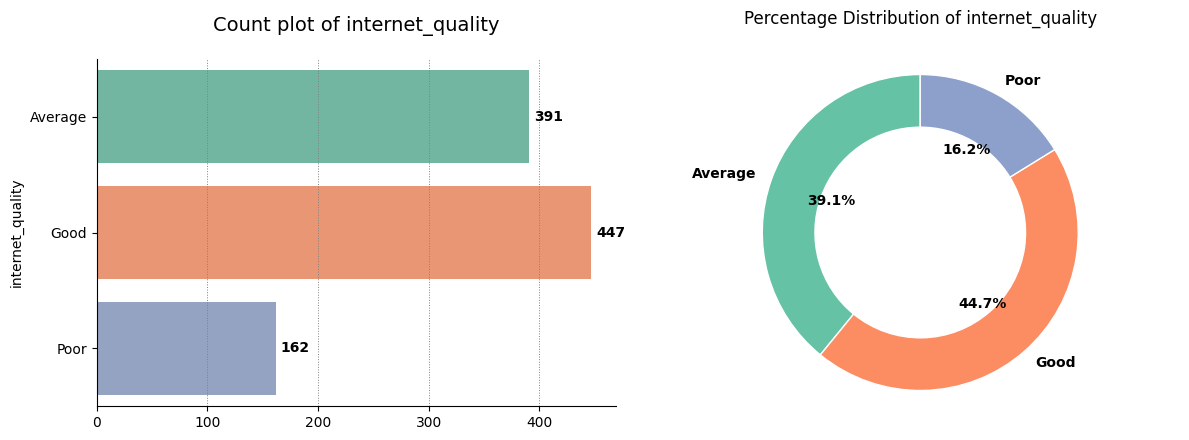

In [27]:
plot_categorical_distribution(feature="internet_quality")

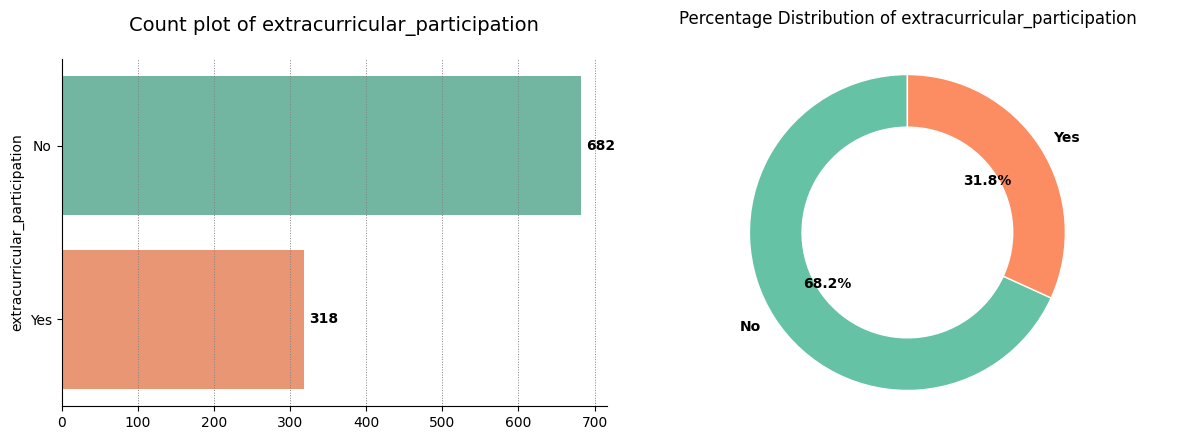

In [28]:
plot_categorical_distribution(feature="extracurricular_participation")

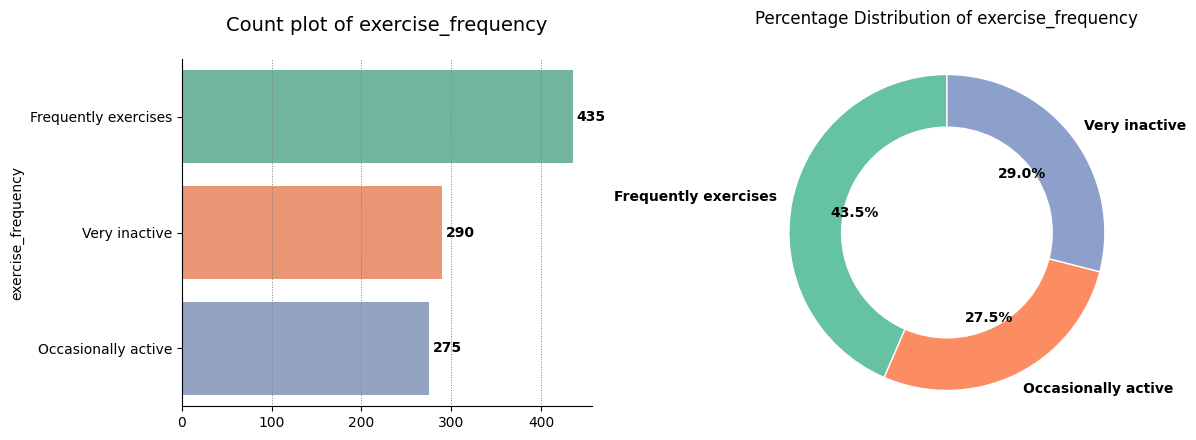

In [29]:
plot_categorical_distribution(feature="exercise_frequency")

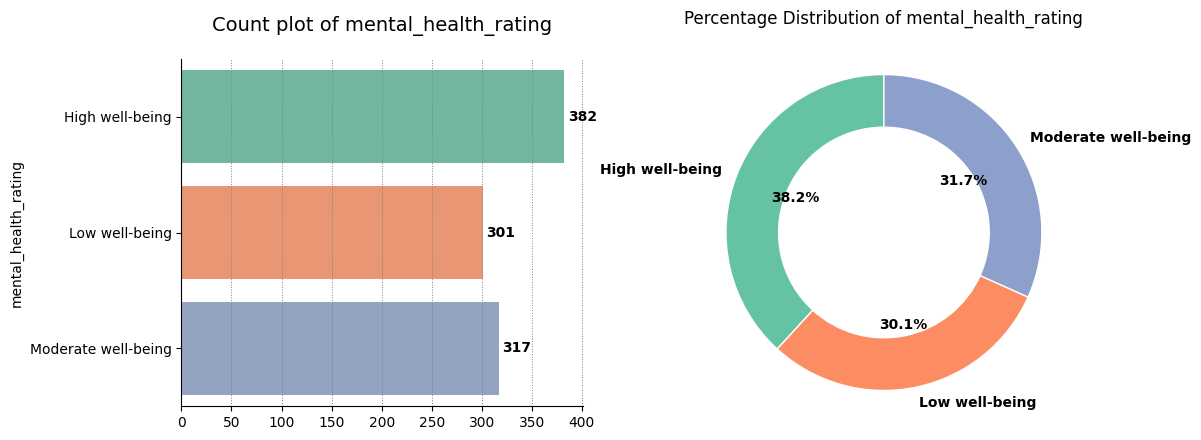

In [30]:
plot_categorical_distribution(feature="mental_health_rating")

In [31]:
# Function to create scatter plot for bivariate analysis 
def plot_scatter_with_legend(feature, order = None):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    sns.boxplot(x=feature, y="exam_score", data=df_student, hue=feature, palette="Set2", ax=ax[0])
    ax[0].set_title(f"Box plot of {feature} distribution by exam_score", pad=15)
    ax[0].set_ylabel("exam_score", labelpad=10)
    ax[0].grid(axis="y", color="gray", linestyle=":", alpha=0.7)

    sns.histplot(data=df_student, x="exam_score", hue=feature, 
                 bins=20, palette="Set2", ax=ax[1], kde=True)
    ax[1].set_title(f"Histogram of {feature} distribution by exam_score", pad=15)
    ax[1].set_xlabel("exam_score", labelpad=10)
    ax[1].set_ylabel("Frequency", labelpad=10)
    ax[1].grid(axis="y", color="gray", linestyle=":", alpha=0.7)

    plt.tight_layout()
    plt.show()

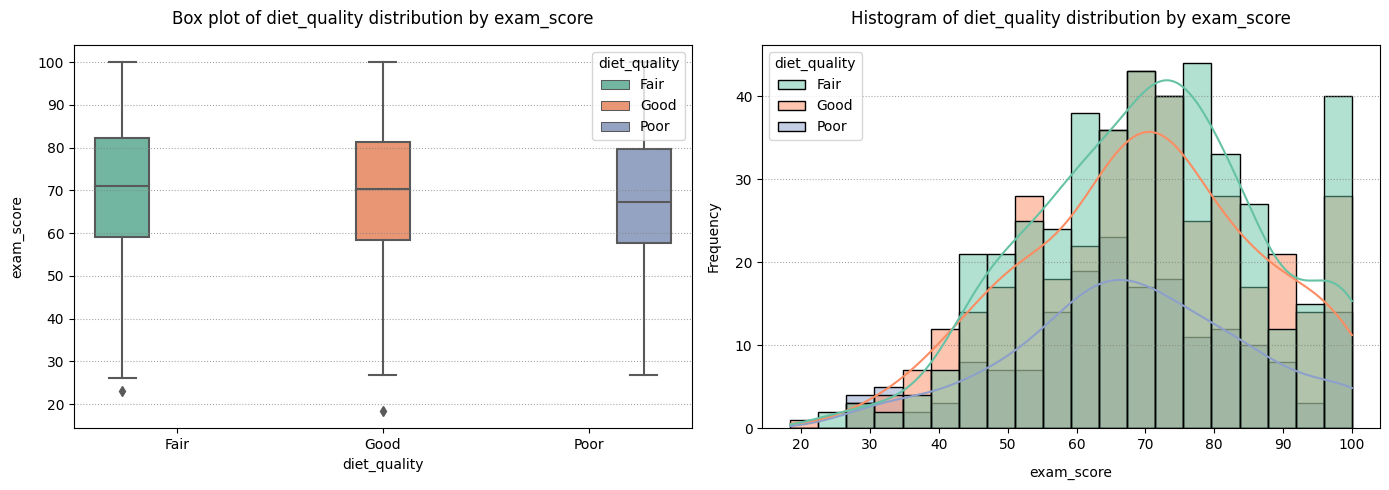

In [32]:
# Calling the function for diet_quality
plot_scatter_with_legend(feature="diet_quality")

In [34]:
!pip install scikit-posthocs
cal_shapiro(cat_feature="diet_quality", num_feature="exam_score", df=df_student)
# cal_levene(dataframe=df_student_new, categorical_feature="gender", num_feature="exam_score")
perform_kruskal_test(df=df_student, categorical_feature="diet_quality", numeric_feature="exam_score")

🔎 Shapiro-Wilk Normality Test for exam_score across diet_quality groups
Group: Fair
  Shapiro-Wilk statistic: 0.985
  p-value: 0.000153
  ⚪ Fair does not appear to follow a normal distribution.

Group: Good
  Shapiro-Wilk statistic: 0.986
  p-value: 0.001165
  ⚪ Good does not appear to follow a normal distribution.

Group: Poor
  Shapiro-Wilk statistic: 0.984
  p-value: 0.033151
  ⚪ Poor does not appear to follow a normal distribution.


🔍 Kruskal-Wallis Test: exam_score ~ diet_quality
Kruskal-Wallis H-statistic: 2.460
p-value: 0.29226543377608316

ℹ️ No significant difference found (p >= 0.05)


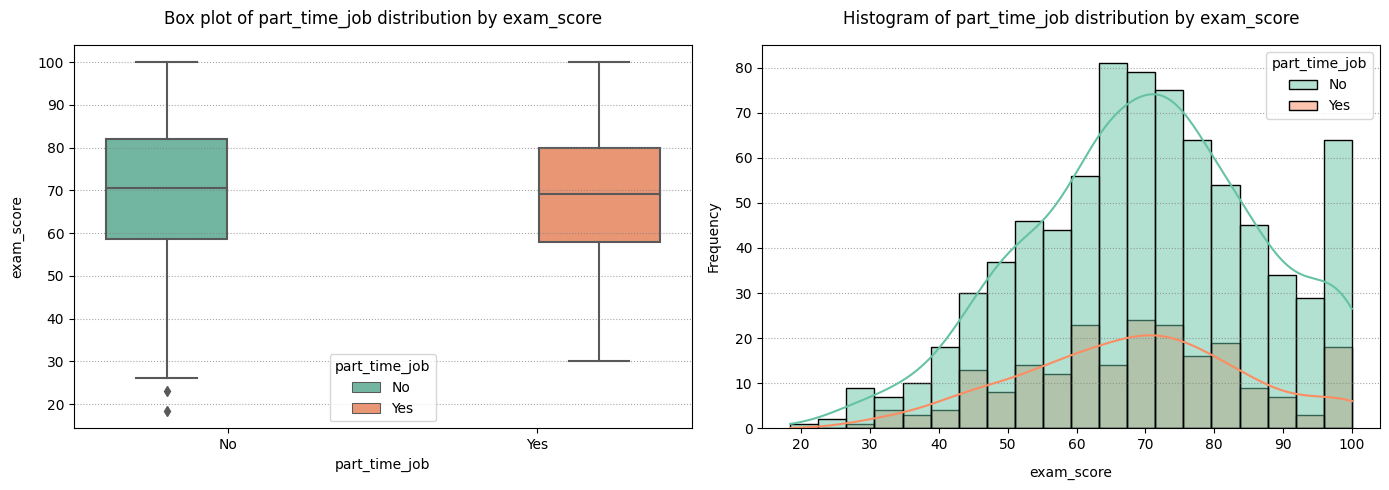

In [35]:
# Calling the function for part_time_job
plot_scatter_with_legend(feature="part_time_job")

In [36]:
cal_shapiro(cat_feature="part_time_job", num_feature="exam_score", df=df_student)
cal_mannwhitneyu(dataframe=df_student, categorical_feature="part_time_job", num_feature="exam_score")

🔎 Shapiro-Wilk Normality Test for exam_score across part_time_job groups
Group: No
  Shapiro-Wilk statistic: 0.986
  p-value: 0.000001
  ⚪ No does not appear to follow a normal distribution.

Group: Yes
  Shapiro-Wilk statistic: 0.985
  p-value: 0.019337
  ⚪ Yes does not appear to follow a normal distribution.

🔍 Mann-Whitney U test: exam_score ~ part_time_job
Mann-Whitney U statistic: 87986.500
p-value: 0.33750514845947854
⚪ There is no significant difference between the two groups.


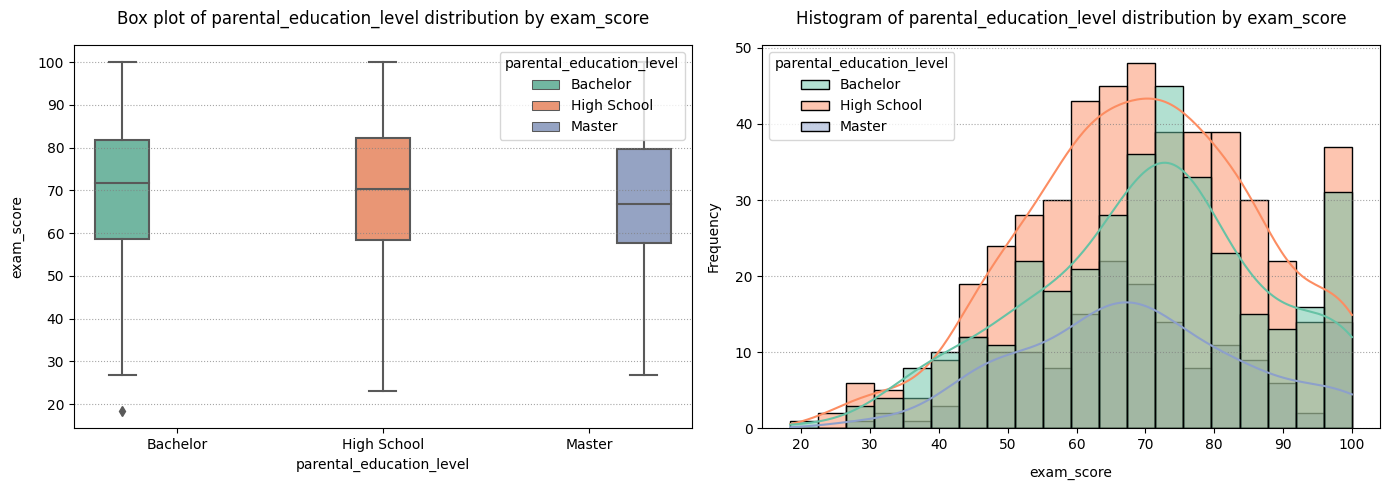

In [37]:
# Calling the function for parental_education_level
plot_scatter_with_legend(feature="parental_education_level")

In [38]:
cal_shapiro(cat_feature="parental_education_level", num_feature="exam_score", df=df_student)
perform_kruskal_test(df=df_student, categorical_feature="parental_education_level", numeric_feature="exam_score")

🔎 Shapiro-Wilk Normality Test for exam_score across parental_education_level groups
Group: Master
  Shapiro-Wilk statistic: 0.985
  p-value: 0.061834
  🟢 Master appears to follow a normal distribution.

Group: High School
  Shapiro-Wilk statistic: 0.987
  p-value: 0.000290
  ⚪ High School does not appear to follow a normal distribution.

Group: Bachelor
  Shapiro-Wilk statistic: 0.981
  p-value: 0.000138
  ⚪ Bachelor does not appear to follow a normal distribution.


🔍 Kruskal-Wallis Test: exam_score ~ parental_education_level
Kruskal-Wallis H-statistic: 3.017
p-value: 0.22125746930673001

ℹ️ No significant difference found (p >= 0.05)


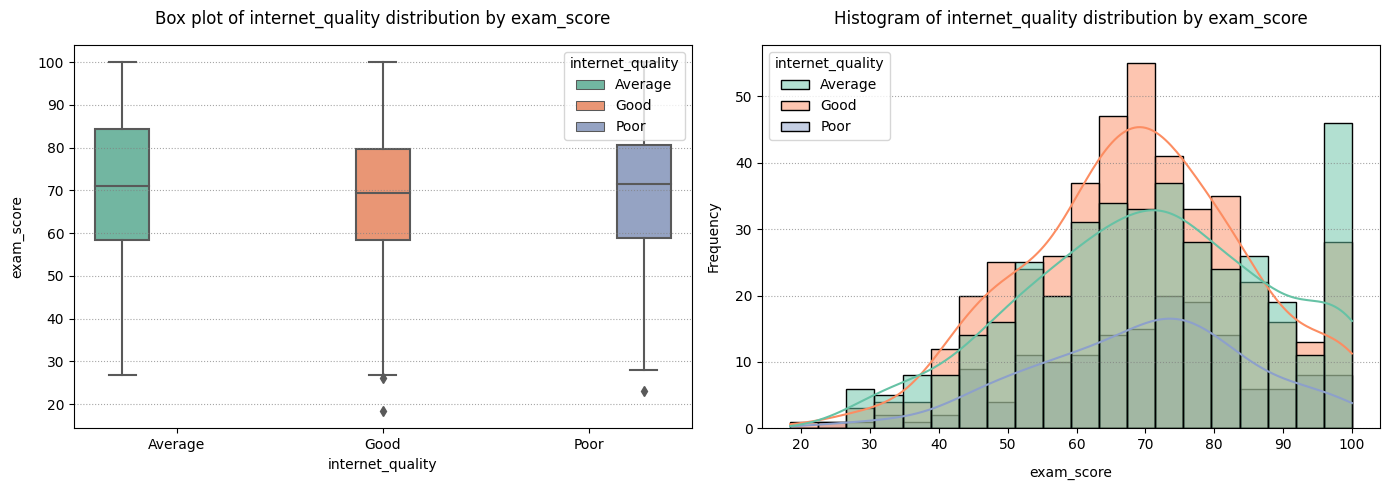

In [39]:
# Calling the function for internet_quality
plot_scatter_with_legend(feature="internet_quality")

In [40]:
cal_shapiro(cat_feature="internet_quality", num_feature="exam_score", df=df_student)
perform_kruskal_test(df=df_student, categorical_feature="internet_quality", numeric_feature="exam_score")

🔎 Shapiro-Wilk Normality Test for exam_score across internet_quality groups
Group: Average
  Shapiro-Wilk statistic: 0.977
  p-value: 0.000007
  ⚪ Average does not appear to follow a normal distribution.

Group: Poor
  Shapiro-Wilk statistic: 0.987
  p-value: 0.154800
  🟢 Poor appears to follow a normal distribution.

Group: Good
  Shapiro-Wilk statistic: 0.991
  p-value: 0.005760
  ⚪ Good does not appear to follow a normal distribution.


🔍 Kruskal-Wallis Test: exam_score ~ internet_quality
Kruskal-Wallis H-statistic: 3.221
p-value: 0.19975799442666467

ℹ️ No significant difference found (p >= 0.05)


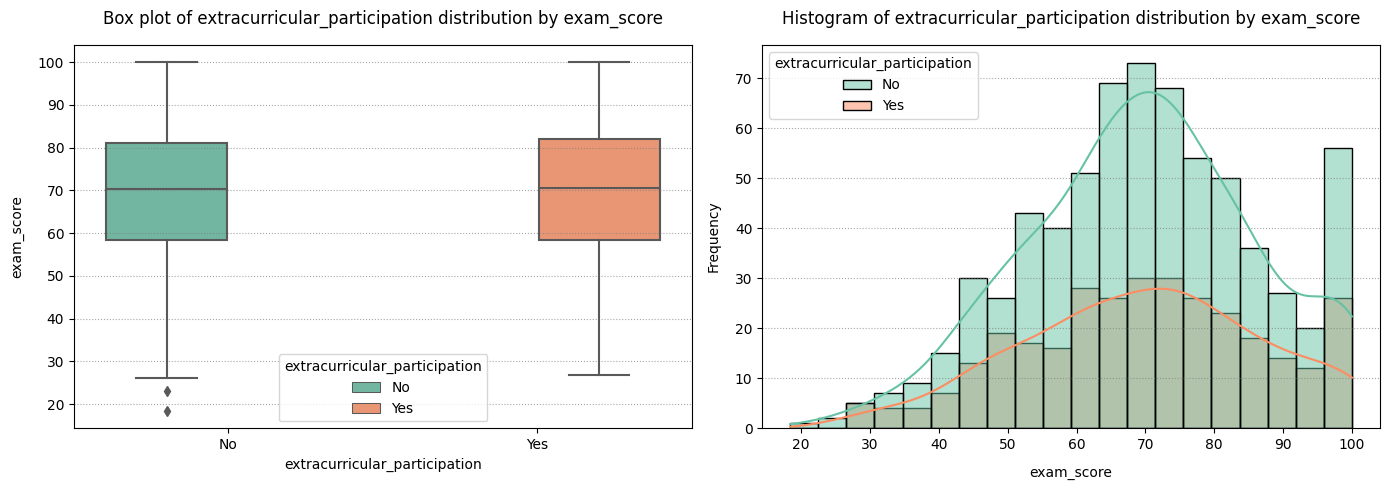

In [41]:
# Calling the function for extracurricular_participation
plot_scatter_with_legend(feature="extracurricular_participation")

In [42]:
cal_shapiro(cat_feature="extracurricular_participation", num_feature="exam_score", df=df_student)
cal_mannwhitneyu(dataframe=df_student, categorical_feature="extracurricular_participation", num_feature="exam_score")

🔎 Shapiro-Wilk Normality Test for exam_score across extracurricular_participation groups
Group: Yes
  Shapiro-Wilk statistic: 0.984
  p-value: 0.001245
  ⚪ Yes does not appear to follow a normal distribution.

Group: No
  Shapiro-Wilk statistic: 0.987
  p-value: 0.000014
  ⚪ No does not appear to follow a normal distribution.

🔍 Mann-Whitney U test: exam_score ~ extracurricular_participation
Mann-Whitney U statistic: 108855.000
p-value: 0.9219891594953306
⚪ There is no significant difference between the two groups.


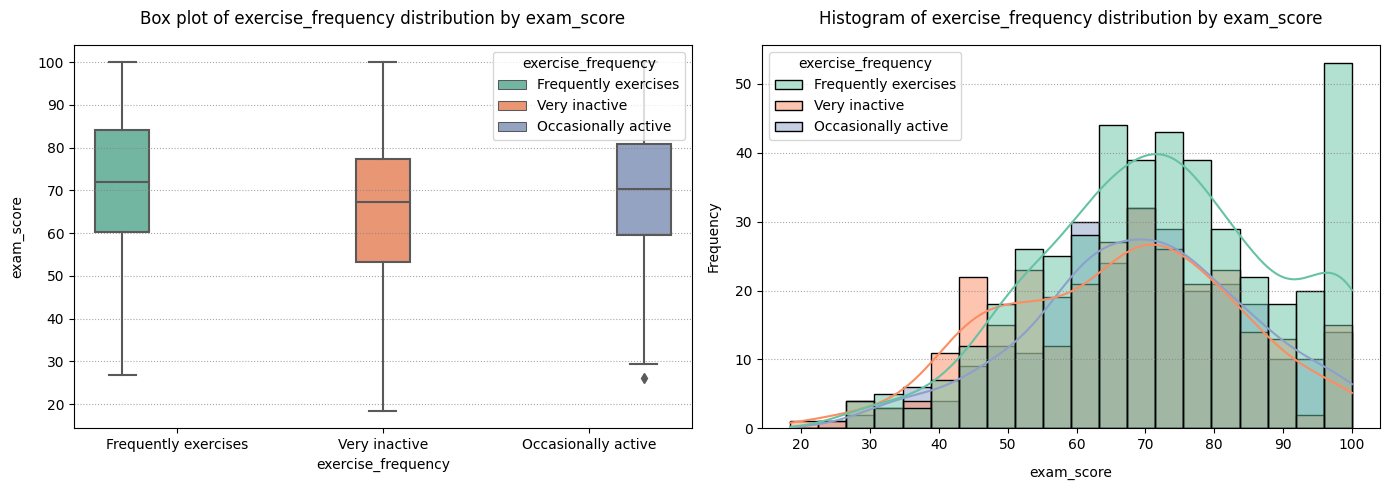

In [43]:
# Calling the function for exercise_frequency
plot_scatter_with_legend(feature="exercise_frequency")

In [44]:
cal_shapiro(cat_feature="exercise_frequency", num_feature="exam_score", df=df_student)
perform_kruskal_test(df=df_student, categorical_feature="exercise_frequency", numeric_feature="exam_score")

🔎 Shapiro-Wilk Normality Test for exam_score across exercise_frequency groups
Group: Frequently exercises
  Shapiro-Wilk statistic: 0.977
  p-value: 0.000003
  ⚪ Frequently exercises does not appear to follow a normal distribution.

Group: Very inactive
  Shapiro-Wilk statistic: 0.989
  p-value: 0.026371
  ⚪ Very inactive does not appear to follow a normal distribution.

Group: Occasionally active
  Shapiro-Wilk statistic: 0.989
  p-value: 0.030053
  ⚪ Occasionally active does not appear to follow a normal distribution.


🔍 Kruskal-Wallis Test: exam_score ~ exercise_frequency
Kruskal-Wallis H-statistic: 19.462
p-value: 5.940382430545654e-05
🟢 Significant difference found. Running Dunn's Post-Hoc Test...
                      Frequently exercises  Occasionally active  Very inactive
Frequently exercises              1.000000             0.123423       0.000033
Occasionally active               0.123423             1.000000       0.109153
Very inactive                     0.000033        

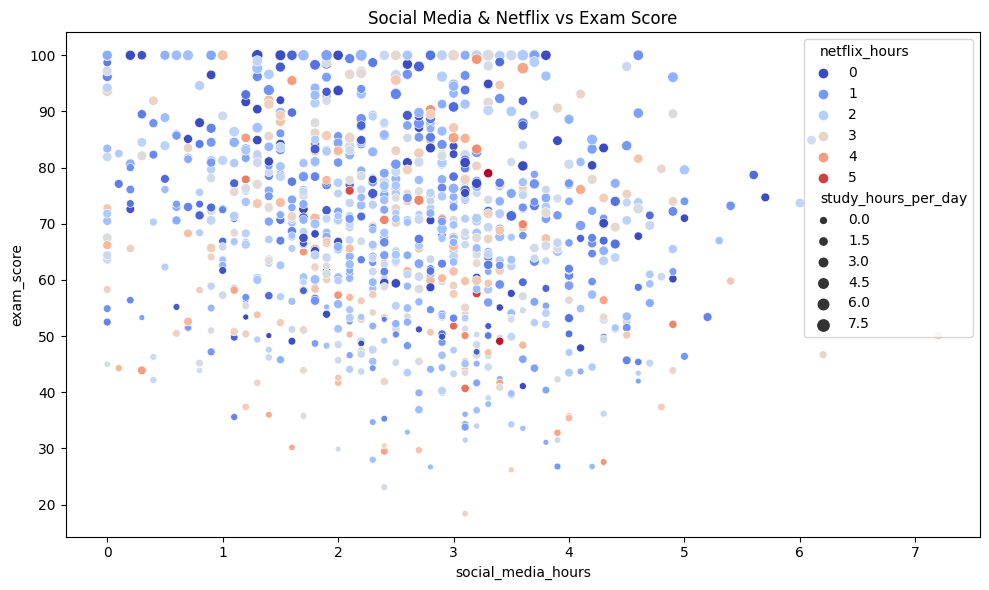

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_student,
    x="social_media_hours",
    y="exam_score",
    hue="netflix_hours",
    size="study_hours_per_day",
    palette="coolwarm"
)
plt.title("Social Media & Netflix vs Exam Score")
plt.tight_layout()
plt.show()

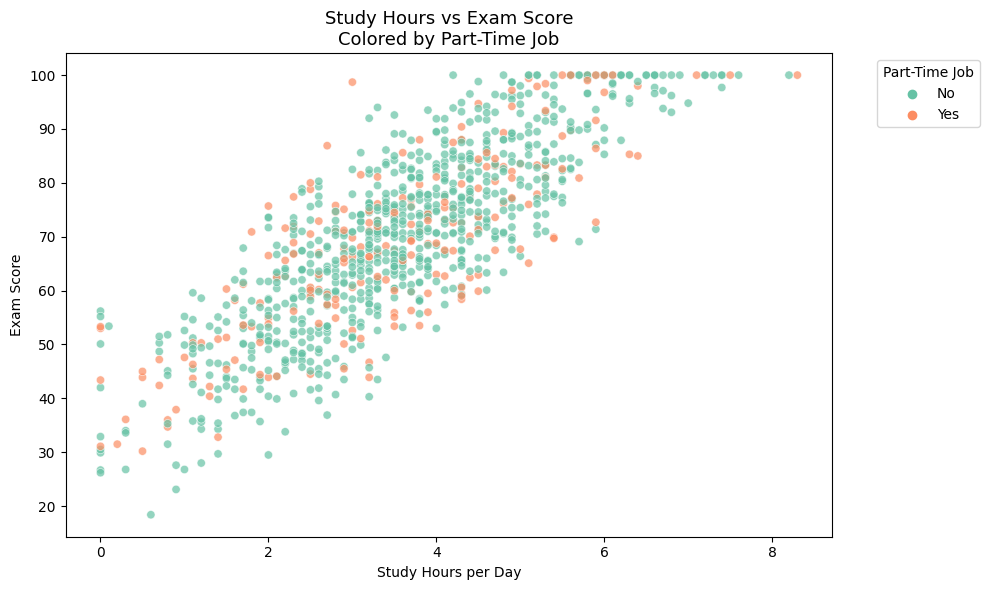

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_student,
    x="study_hours_per_day",
    y="exam_score",
    hue="part_time_job",
    palette="Set2",
    alpha=0.7
)

plt.title("Study Hours vs Exam Score\nColored by Part-Time Job", fontsize=13)
plt.xlabel("Study Hours per Day")
plt.ylabel("Exam Score")
plt.legend(title="Part-Time Job", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

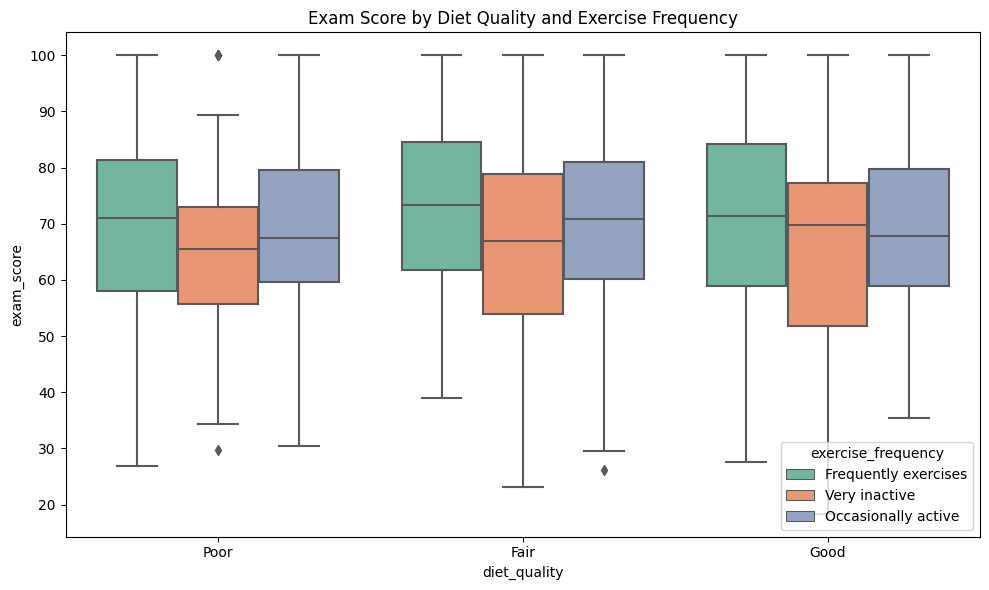

In [47]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_student,
    x="diet_quality",
    y="exam_score",
    hue="exercise_frequency",
    palette="Set2",
    order=["Poor", "Fair", "Good"]
)
plt.title("Exam Score by Diet Quality and Exercise Frequency")
plt.tight_layout()
plt.show()

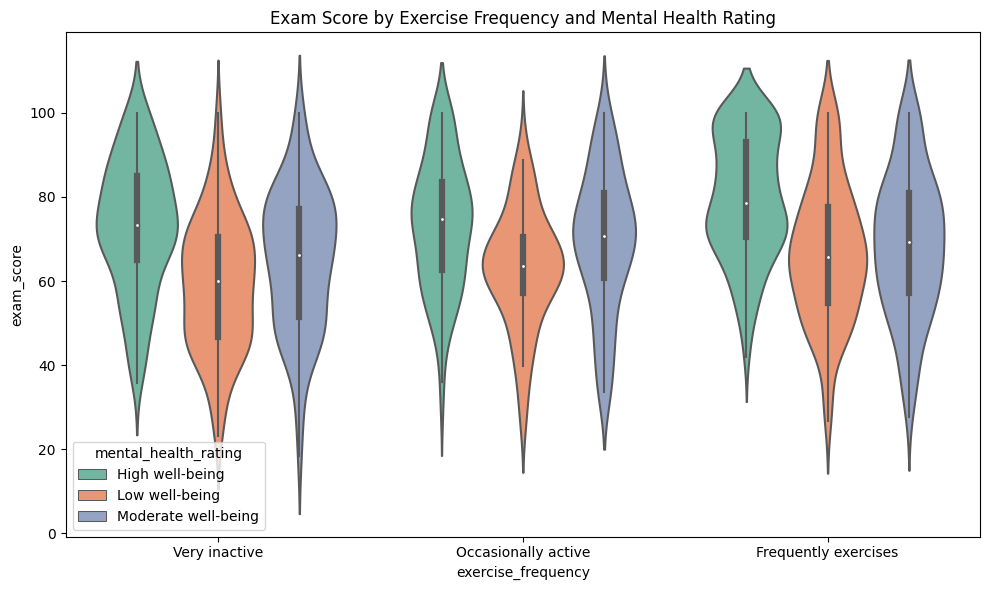

In [48]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_student,
    x="exercise_frequency",
    y="exam_score",
    hue="mental_health_rating",
    palette="Set2",
    order=["Very inactive", "Occasionally active", "Frequently exercises"]
);
plt.title("Exam Score by Exercise Frequency and Mental Health Rating")
plt.tight_layout()
plt.show()

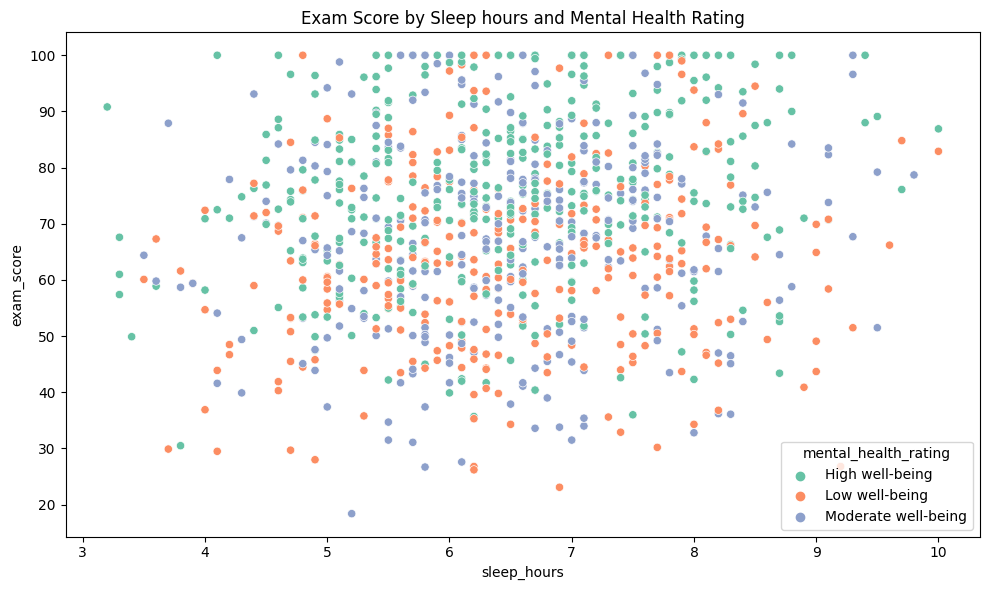

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_student,
    x='sleep_hours',
    y='exam_score',
    hue='mental_health_rating',
    palette='Set2'
)
plt.title("Exam Score by Sleep hours and Mental Health Rating")
plt.tight_layout()
plt.show()

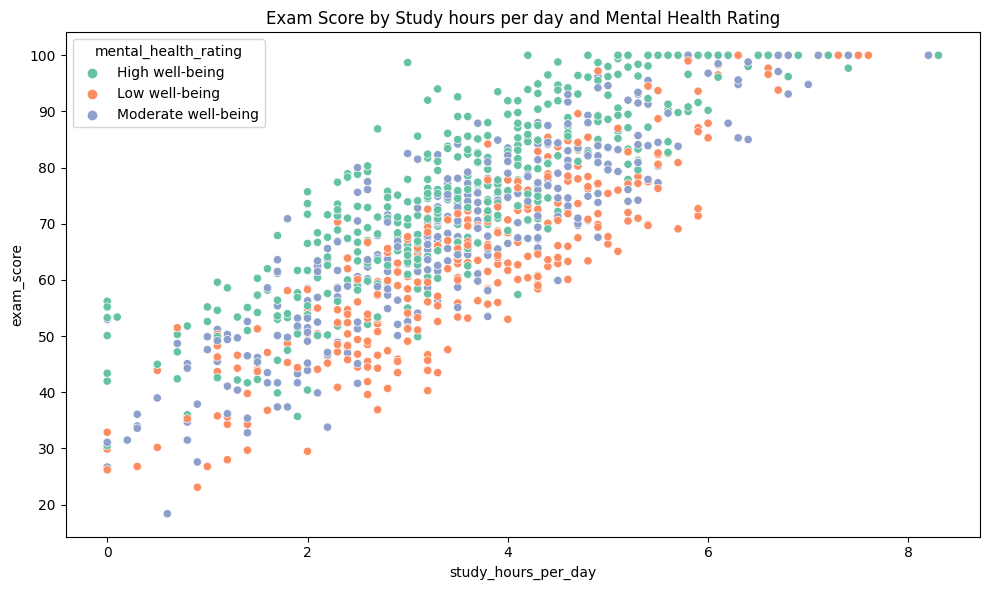

In [50]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_student,
    x="study_hours_per_day",
    y="exam_score",
    hue="mental_health_rating",
    palette="Set2"
);
plt.title("Exam Score by Study hours per day and Mental Health Rating")
plt.tight_layout()
plt.show()

In [51]:
# df_student.reset_index(drop=True, inplace=True) # reset index
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_student, df_student["exam_score_cat"]):
    strat_train_set = df_student.loc[train_index]
    strat_test_set = df_student.loc[test_index]

In [52]:
df_student_new = strat_train_set.drop(columns="exam_score", axis=1)
df_student_new_labels = strat_train_set["exam_score"].copy()

In [53]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("exam_score_cat", axis=1, inplace=True)

In [54]:
num_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

In [55]:
num_feature = ["age",  "study_hours_per_day",  "social_media_hours",  "netflix_hours",  "attendance_percentage",  "sleep_hours"]


In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_feature),
        ("cat", cat_transformer, cat_features),
    ]
)
preprocessor.fit(df_student_new)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'study_hours_per_day',
                                  'social_media_hours', 'netflix_hours',
                                  'attendance_percentage', 'sleep_hours']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['gender', 'part_time_job', 'diet_quality',
                                  'parental_education_level',
                                  'internet_quality',
                                  'extracurricular_participation',
                                  'exercise_frequency',
                                  'mental_health_rating'])])

In [57]:
df_student_new_prepared = preprocessor.transform(df_student_new)

In [58]:
list_feature_prepared = preprocessor.get_feature_names_out().tolist()
list_feature_prepared

['num__age',
 'num__study_hours_per_day',
 'num__social_media_hours',
 'num__netflix_hours',
 'num__attendance_percentage',
 'num__sleep_hours',
 'cat__gender_Female',
 'cat__gender_Male',
 'cat__gender_Other',
 'cat__part_time_job_No',
 'cat__part_time_job_Yes',
 'cat__diet_quality_Fair',
 'cat__diet_quality_Good',
 'cat__diet_quality_Poor',
 'cat__parental_education_level_Bachelor',
 'cat__parental_education_level_High School',
 'cat__parental_education_level_Master',
 'cat__internet_quality_Average',
 'cat__internet_quality_Good',
 'cat__internet_quality_Poor',
 'cat__extracurricular_participation_No',
 'cat__extracurricular_participation_Yes',
 'cat__exercise_frequency_Frequently exercises',
 'cat__exercise_frequency_Occasionally active',
 'cat__exercise_frequency_Very inactive',
 'cat__mental_health_rating_High well-being',
 'cat__mental_health_rating_Low well-being',
 'cat__mental_health_rating_Moderate well-being']

In [59]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

seed = 42
max_iter = 10000
models = [
    LinearRegression(),
    Lasso(alpha=1.0, max_iter=max_iter, random_state=seed),
    Ridge(alpha=0.1, max_iter=max_iter, random_state=seed),
    ElasticNet(alpha=0.1, max_iter=max_iter, random_state=seed),
    DecisionTreeRegressor(max_depth=5, random_state=seed),
    RandomForestRegressor(n_estimators=100, random_state=seed),
    GradientBoostingRegressor(random_state=seed),
    AdaBoostRegressor(random_state=seed),
    ExtraTreesRegressor(random_state=seed),
    SVR(kernel="rbf", max_iter=max_iter),
    LinearSVR(max_iter=max_iter, random_state=seed),
    MLPRegressor(max_iter=max_iter, random_state=seed),
    KNeighborsRegressor(n_neighbors=5),
    XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=seed)
]

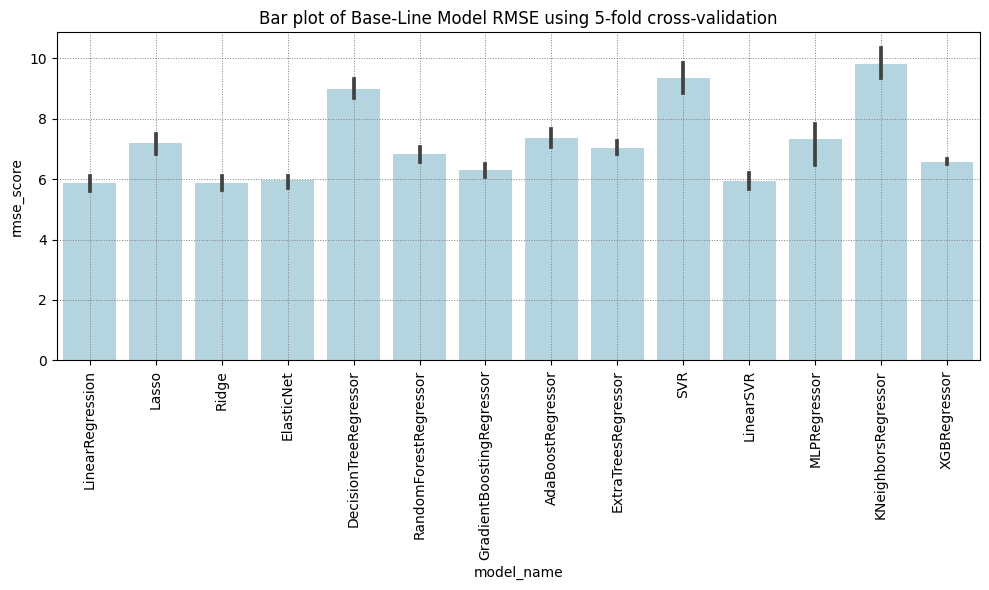

,Mean,Standard Deviation
model_name,,
Ridge,5.868019,0.324083
LinearRegression,5.878000,0.330799
LinearSVR,5.936362,0.358769
ElasticNet,5.962928,0.266597
GradientBoostingRegressor,6.307625,0.257405
XGBRegressor,6.585160,0.114919
RandomForestRegressor,6.820855,0.325868
ExtraTreesRegressor,7.043497,0.283440
Lasso,7.184854,0.430624


In [60]:
def generate_baseline_results_RMSE(models, X, y, metrics, cv = 5, plot_results = False):
    # define K -Fold
    kfold = KFold(cv, shuffle=True, random_state=seed)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_val_score(model, X, y, scoring=metrics, cv=kfold)
        rmse_scores = np.sqrt(-scores)
        for fold_idx, rmse_score in enumerate(rmse_scores):
            entries.append((model_name, fold_idx, rmse_score))
    cv_df = pd.DataFrame(entries, columns=["model_name", "fold_id", "rmse_score"])

    if plot_results:
        plt.figure(figsize=(10, 6))
        sns.barplot(x = "model_name", y = "rmse_score", data = cv_df, color="lightblue")
        plt.title("Bar plot of Base-Line Model RMSE using 5-fold cross-validation")
        plt.grid(color="gray", linestyle=":", linewidth=0.7)
        plt.xticks(rotation = 90)
        plt.tight_layout()
        plt.show()
    else:
        pass

    # Summary
    mean_rmse_score = cv_df.groupby("model_name")["rmse_score"].mean()
    std_rmse_score = cv_df.groupby("model_name")["rmse_score"].std()

    baseline_result = pd.concat([mean_rmse_score, std_rmse_score], axis=1, ignore_index=True)
    baseline_result.columns = ["Mean", "Standard Deviation"]

    # Sort by accuracy
    baseline_result.sort_values(by=["Mean"], ascending=True, inplace=True)
    return baseline_result

generate_baseline_results_RMSE(models = models, X = df_student_new_prepared,
                          y = df_student_new_labels, metrics = "neg_mean_squared_error", plot_results = True)

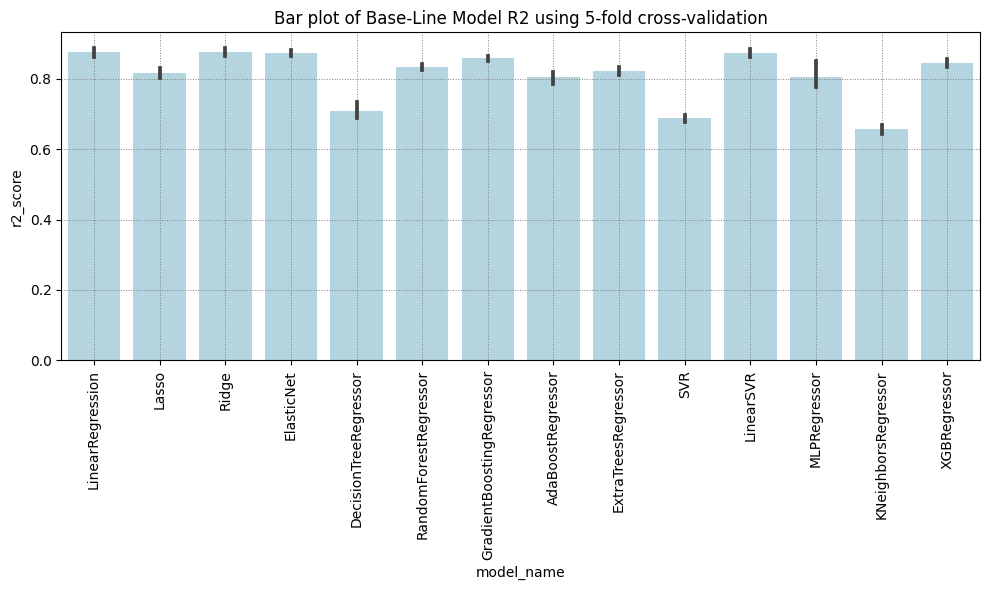

,Mean,Standard Deviation
model_name,,
Ridge,0.876297,0.015405
LinearRegression,0.875920,0.015113
LinearSVR,0.873445,0.015986
ElasticNet,0.872584,0.010482
GradientBoostingRegressor,0.857511,0.009638
XGBRegressor,0.844136,0.015774
RandomForestRegressor,0.833501,0.010242
ExtraTreesRegressor,0.822098,0.015468
Lasso,0.814991,0.018405


In [61]:
def generate_baseline_results_R2(models, X, y, metrics, cv = 5, plot_results = False):
    # define K -Fold
    kfold = KFold(cv, shuffle=True, random_state=seed)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_val_score(model, X, y, scoring=metrics, cv=kfold)
        for fold_idx, r2_score in enumerate(scores):
            entries.append((model_name, fold_idx, r2_score))
    cv_df = pd.DataFrame(entries, columns=["model_name", "fold_id", "r2_score"])

    if plot_results:
        plt.figure(figsize=(10, 6))
        sns.barplot(x = "model_name", y = "r2_score", data = cv_df, color="lightblue")
        plt.title("Bar plot of Base-Line Model R2 using 5-fold cross-validation")
        plt.grid(color="gray", linestyle=":", linewidth=0.7)
        plt.xticks(rotation = 90)
        plt.tight_layout()
        plt.show()
    else:
        pass

    # Summary
    mean_r2_score = cv_df.groupby("model_name")["r2_score"].mean()
    std_r2_score = cv_df.groupby("model_name")["r2_score"].std()

    baseline_result = pd.concat([mean_r2_score, std_r2_score], axis=1, ignore_index=True)
    baseline_result.columns = ["Mean", "Standard Deviation"]

    # Sort by accuracy
    baseline_result.sort_values(by=["Mean"], ascending=False, inplace=True)
    return baseline_result

generate_baseline_results_R2(models = models, X = df_student_new_prepared,
                          y = df_student_new_labels, metrics = "r2", plot_results = True)


In [62]:
best_models = {
    "Ridge": Ridge(alpha=0.1, max_iter=max_iter, random_state=seed),
    "LinearRegression": LinearRegression(),
    "LinearSVR": LinearSVR(max_iter=max_iter, random_state=seed),
    "ElasticNet": ElasticNet(alpha=0.1, max_iter=max_iter, random_state=seed)
}

In [63]:
# Function to evaluate regression models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Metrics for regression
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print("-"*80)

    print(f"Feature Coef...")
    feature_coef_df = pd.DataFrame({"Feature": list_feature_prepared, "Coefficient": model.coef_})
    feature_coef_sorted_df = feature_coef_df.sort_values(by = "Coefficient", ascending=False)
    print(feature_coef_sorted_df.head())

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_coef_sorted_df,  x="Coefficient", y="Feature", color="blue")
    plt.grid(color="gray", linestyle=":", linewidth=0.7)
    plt.title("Feature Coefficients")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Features")
    plt.axvline(x=0, color="black", linewidth=0.8)
    plt.tight_layout()
    plt.show()

Evaluating Ridge...
Model: Ridge
Root Mean Squared Error (RMSE): 5.4716
R-squared (R2): 0.8989
--------------------------------------------------------------------------------
Feature Coef...
                                         Feature  Coefficient
1                       num__study_hours_per_day    13.925576
25     cat__mental_health_rating_High well-being     6.527505
22  cat__exercise_frequency_Frequently exercises     3.216998
5                               num__sleep_hours     2.553148
4                     num__attendance_percentage     1.481860


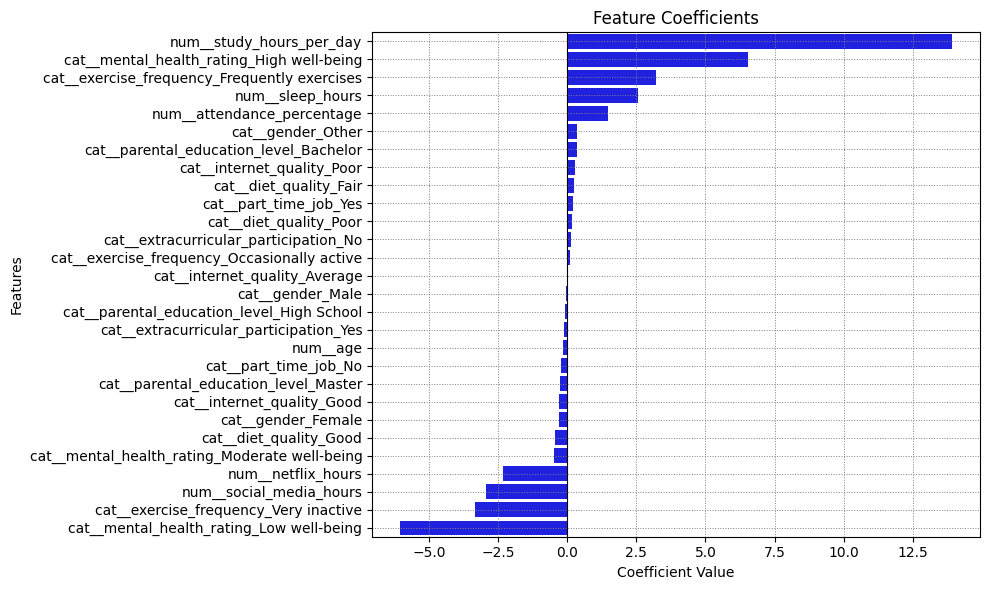


Evaluating LinearRegression...
Model: LinearRegression
Root Mean Squared Error (RMSE): 5.4713
R-squared (R2): 0.8989
--------------------------------------------------------------------------------
Feature Coef...
                                         Feature  Coefficient
1                       num__study_hours_per_day    13.927402
25     cat__mental_health_rating_High well-being     6.529878
22  cat__exercise_frequency_Frequently exercises     3.218170
5                               num__sleep_hours     2.553550
4                     num__attendance_percentage     1.482119


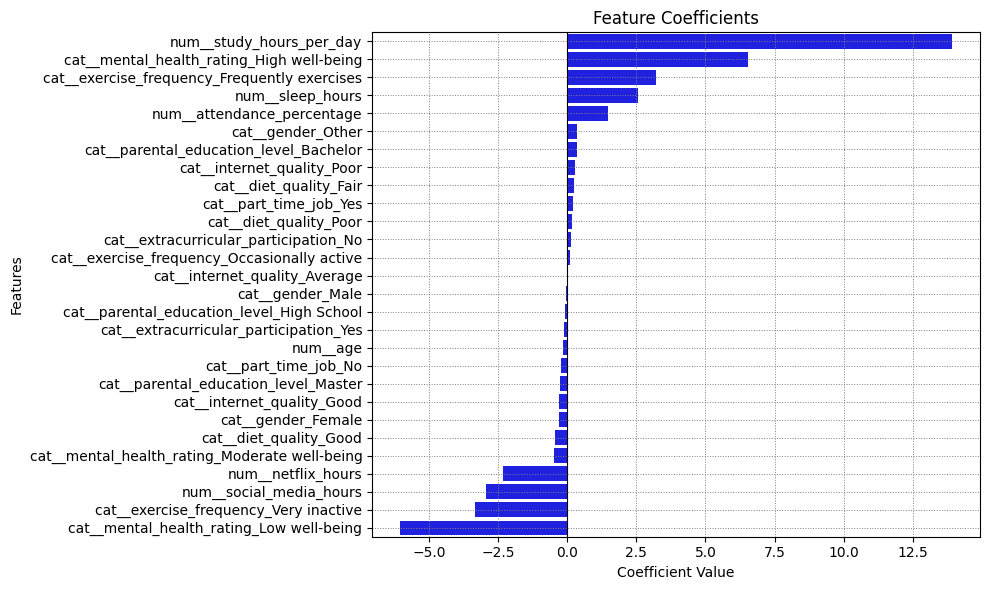


Evaluating LinearSVR...
Model: LinearSVR
Root Mean Squared Error (RMSE): 5.5453
R-squared (R2): 0.8962
--------------------------------------------------------------------------------
Feature Coef...
                                         Feature  Coefficient
1                       num__study_hours_per_day    13.796084
25     cat__mental_health_rating_High well-being    12.121039
22  cat__exercise_frequency_Frequently exercises     8.928109
9                          cat__part_time_job_No     8.753005
20         cat__extracurricular_participation_No     8.704633


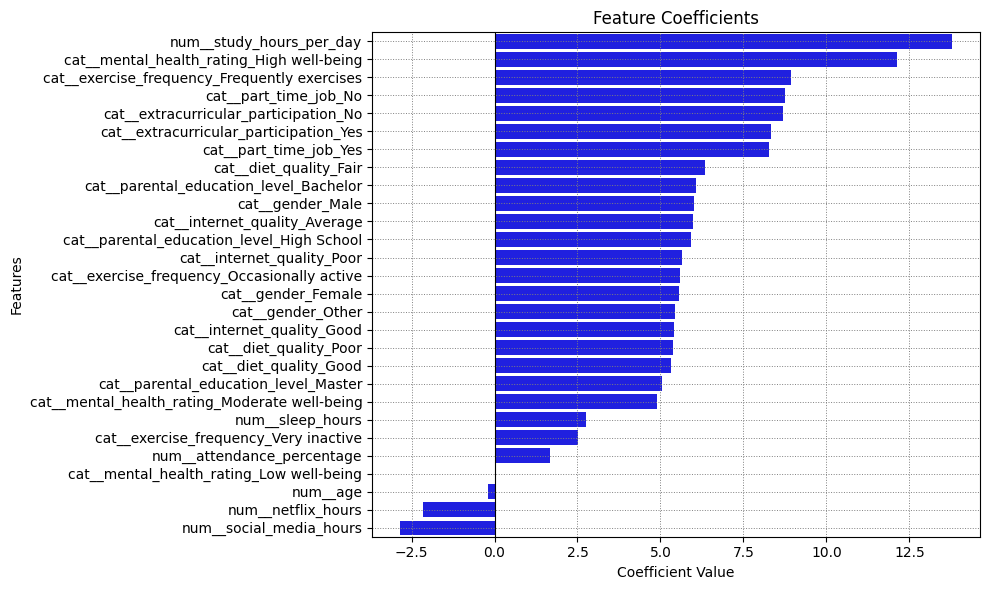


Evaluating ElasticNet...
Model: ElasticNet
Root Mean Squared Error (RMSE): 5.7036
R-squared (R2): 0.8902
--------------------------------------------------------------------------------
Feature Coef...
                                         Feature  Coefficient
1                       num__study_hours_per_day    13.182487
25     cat__mental_health_rating_High well-being     5.895711
22  cat__exercise_frequency_Frequently exercises     2.638809
5                               num__sleep_hours     2.348254
4                     num__attendance_percentage     1.343220


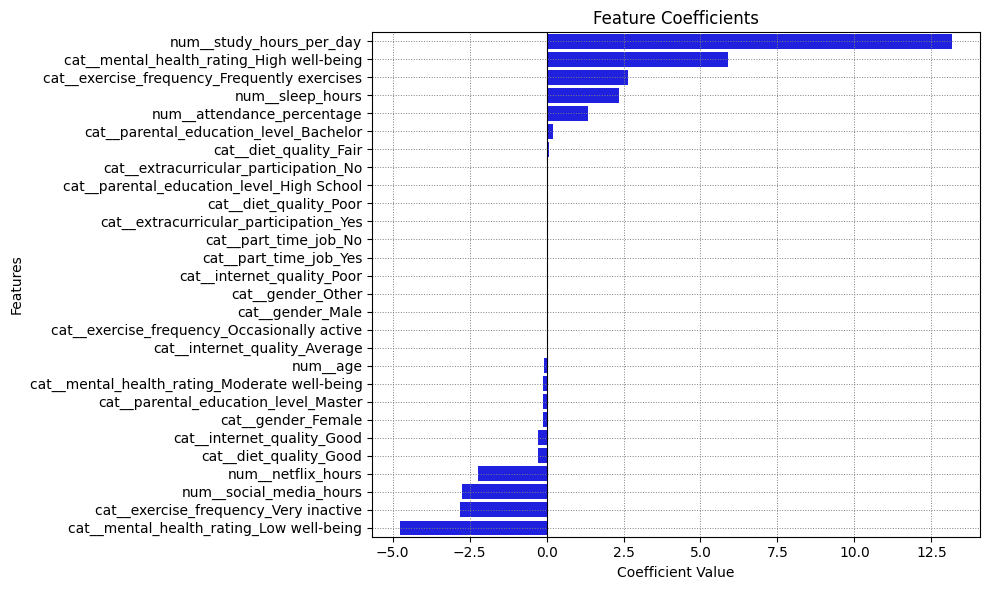

In [64]:
X_test = strat_test_set.drop("exam_score", axis=1)
y_test = strat_test_set["exam_score"].copy()
X_test_prepared = preprocessor.transform(X_test)

# Train and evaluate each regression model
for model_name, model in best_models.items():
    print(f"Evaluating {model_name}...")
    evaluate_model(model, X_train = df_student_new_prepared, 
                   X_test = X_test_prepared , y_train = df_student_new_labels, y_test = y_test)
    print()    

In [65]:
import joblib

# Save preprocessor
joblib.dump(preprocessor, "preprocessor.pkl")

# Save each best model
for name, model in best_models.items():
    joblib.dump(model, f"{name}_model.pkl")


In [66]:
import joblib

# Load saved preprocessor
preprocessor = joblib.load("preprocessor.pkl")

# Load the best model (Ridge)
ridge_model = joblib.load("Ridge_model.pkl")


In [70]:
import pandas as pd

# New student data
df_new = pd.DataFrame([
    {
        "age": 19,
        "study_hours_per_day": 5,
        "social_media_hours": 3,
        "netflix_hours": 2,
        "attendance_percentage": 50,
        "sleep_hours": 7,
        "gender": "Female",
        "part_time_job": "No",
        "diet_quality": "Good",
        "parental_education_level": "Bachelor",
        "internet_quality": "Good",
        "extracurricular_participation": "Yes",
        "exercise_frequency": "Frequently exercises",
        "mental_health_rating": "High well-being"
    }
])


In [71]:
# Apply the same transformations as the training data
X_new_prepared = preprocessor.transform(df_new)


In [72]:
# Predict exam score
y_new_pred = ridge_model.predict(X_new_prepared)

print(f"Predicted exam score for the new student: {y_new_pred[0]:.2f}")


Predicted exam score for the new student: 85.42
